## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
## Importing useful Packages

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from pylab import *
import math
import os
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


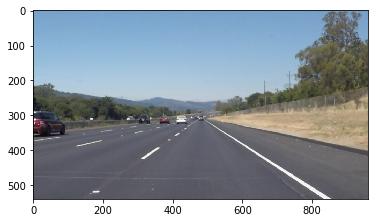

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images  
`cv2.cvtColor()` to grayscale or change color  
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image
            
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines) # draw new lines using linear regression 
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.7, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

In [4]:
def x_intersection(pos_slope,pos_inter,neg_slope,neg_inter):
    return (neg_inter-pos_inter)/(pos_slope-neg_slope)

In [5]:
def check_inf_nan(check):
    check = np.array(check) # transform into array
    check = check[~np.isinf(check)]
    check = check[~np.isnan(check)]
    return check

In [6]:
def find_average_fit(inter_slope):
    
    counter = 0
    new_slope = []
    new_inter = []
    error_factor = 1.2
    
    if len(inter_slope)==1: # If the slope array has only one element [x1,y1,x2,y2]
        return inter_slope[0][0],inter_slope[0][1]

    # Separate slope and intersection to take the averages
    slope = [x[0] for x in inter_slope] 
    inter = [x[1] for x in inter_slope]
    
    # Check for Inf and NaN variables
    slope = check_inf_nan(slope)
    inter = check_inf_nan(inter)
    
    slope_std = np.std(slope) # Estimate the standard deviation
    slope_avg = np.mean(slope)
    inter_avg = np.mean(inter)
    
    # Dealing with the cases where [x1,y1,x2,y2]~[x'1,y'1,x'2,y'2]
    if slope_std == 0:
        return slope_avg,inter_avg
    
    # Filter points with slopes for which the error < error_*standard deviation of the slope
    for value in slope:
        if(value-slope_avg < error_factor*slope_std):
            new_slope.append(value)
            new_inter.append(inter[counter])
        counter+=1    
    
    new_slope_avg = np.mean(new_slope)
    new_inter_avg = np.mean(new_inter)
    return new_slope_avg,new_inter_avg

In [7]:
def draw_line_from_regression(coeff_pos, inter_pos, coeff_neg, inter_neg, inter_x_coord, img, imshape=[540,960],color=[255, 0, 0,.7], thickness=7):
    
    # Scale defines the percentage of the regression line from the top inter_x_coord
    scale = .9
    scale_pos = 1./scale
    count = 0
        
    if coeff_neg < 0:
        
        p_2_x = int(0)
        p_2_y = int(inter_neg)
        p_1_x = int(inter_x_coord*scale)
        p_1_y = int((coeff_neg*inter_x_coord*scale) + inter_neg)
        p_2 = (p_2_x, p_2_y)
        p_1 = (p_1_x, p_1_y)
        
    if coeff_pos > 0:
        
        p_4_x = int(imshape[1])
        p_4_y = int((coeff_pos* imshape[1]) + inter_pos)
        p_3_x = int(inter_x_coord*scale_pos)
        p_3_y = int((coeff_pos*inter_x_coord*scale_pos) + inter_pos)
        p_4 = (p_4_x, p_4_y)
        p_3 = (p_3_x, p_3_y)
    
    cv2.line(img, p_1, p_2, color, thickness) # Line with negative slope coefficient
    cv2.line(img, p_3, p_4, color, thickness) # Line with positive slope coefficient

In [8]:
def add_slope(previous_slope,previous_inter,slope_value,x1,y1,x2,y2):
    add_slope = []
    add_inter = []
    add_slope = previous_slope.copy()
    add_inter = previous_inter.copy()
    add_slope.append([x1, y1])
    add_slope.append([x2, y2])
    add_inter.append([slope_value, y1-slope_value*x1])
    return add_slope,add_inter

In [9]:
def empty_slope(lines,value):
    
    pos_slope = []
    neg_slope = []
    pos_inter = []
    neg_inter = []
   
    if(value=='positive_slope'):
        for line in lines:
            for x1,y1,x2,y2 in line:
                slope = (y2-y1)/(x2-x1)
                if slope > 0:
                    pos_slope,pos_inter = add_slope(pos_slope,pos_inter,slope,x1,y1,x2,y2) 
        return pos_slope,pos_inter
    
    elif(value=='negative_slope'):
        for line in lines:
            for x1,y1,x2,y2 in line:
                slope = (y2-y1)/(x2-x1)
                if slope < 0:
                    neg_slope, neg_inter = add_slope(neg_slope,neg_inter,slope,x1,y1,x2,y2)
        return neg_slope,neg_inter            

In [10]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    
    imshape=[540,960]
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    import math
    pos_slope = []
    neg_slope = []
    pos_inter = []
    neg_inter = []
    
    # We can separate right(negative) and left(positive) lines by checking the slope, length and y intersection.
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            if(x2-x1==0): # Avoid dividing by 0
                break
           # print(x1,y1,x2,y2) #Debugging
            slope = (y2-y1)/(x2-x1)
            #center = [(x1+x2)/2,(y2+y1)/2] # Can be calculated through the center or average.
            line_length= np.sqrt((x2-x1)**2 + (y2-y1)**2)
            #print("Slope,Center,Line_Size = ",slope,";",center,";",line_length)
            # If slope is not empty, append slope and intersection to arrays based on either slope>0 or slope <0
            
            if ~math.isnan(slope):
                if line_length > 60:
                    if slope > 0:
                        pos_slope,pos_inter = add_slope(pos_slope,pos_inter,slope,x1,y1,x2,y2) 
                        #print(pos_inter)
                    elif slope < 0:
                         neg_slope, neg_inter = add_slope(neg_slope,neg_inter,slope,x1,y1,x2,y2)
                        #print(neg_inter)
                
    # If pos_slope or neg_slope are empty:
    if not pos_slope:
        print("positive slope is empty")
        pos_slope,pos_inter = empty_slope(lines,value='positive_slope')
        
    if not neg_slope:
        print("negative slope is empty")
        neg_slope,neg_inter = empty_slope(lines,value='negative_slope')
                
    # Transform List to Numpy array:

    pos_slope,neg_slope = np.array(pos_slope),np.array(neg_slope)

    # Extract an average coefficient from find_average_fit
    ###### modify to take the average of both pos_inter and neg_inter at one shot !
    coef_pos_slope, coef_pos_inter = find_average_fit(pos_inter)
    coef_neg_slope, coef_neg_inter = find_average_fit(neg_inter)
    print("coef_slope_inter: ",coef_pos_slope,coef_pos_inter,coef_neg_slope, coef_neg_inter)
    # Debugging
    #print("coef_pos_slope",coef_pos_slope,"coef_pos_inter",coef_pos_inter)
    #print("coef_neg_slope",coef_neg_slope,"coef_neg_inter",coef_neg_inter)

    x_inter_coord = x_intersection(coef_pos_slope,coef_pos_inter,coef_neg_slope,coef_neg_inter)
    print(x_inter_coord)

    draw_line_from_regression(coef_pos_slope, coef_pos_inter, coef_neg_slope, coef_neg_inter, x_inter_coord, img)

    ##### Debugging pos_slope, pos_inter, neg_slope, neg_inter
    #print("Positive = ",pos_slope)
    #print("Positive Slope,Intercept = ",pos_inter)
    #print("Negative = ",neg_slope)
    #print("Negative Slope,Intercept = ",neg_inter)
            

### Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [11]:
files = os.listdir("test_images/")
if '.DS_Store' in files:
    files.remove('.DS_Store')

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [12]:
# Plot the Polygon from the Vertices/Image
def plot_polygon(vertices,img):
    pts = vertices.reshape((-1, 1, 2))
    cv2.polylines(img, [pts], isClosed=True, color=(0, 0, 255), thickness=10)
    # fill it
    cv2.fillPoly(img, [pts], color=(145, 0, 255,255))
    # show it
    plt.imshow(img)

In [13]:
def plot_images(file,gray,edges,vertices,img2,target,lines,result):
        a=3
        b=2
        scale=13
        fig = plt.figure(figsize=(scale,scale))
        subplot(a,b,1)
        plt.imshow(gray)
        title('Grayscale test_images/'+file)
        subplot(a,b,2)
        plt.imshow(edges)
        title('Edges - Canny test_images/'+file)
        subplot(a,b,3)
        plot_polygon(vertices,img2)
        title('Polygon from Vertices test_images/'+file)
        subplot(a,b,4)
        plt.imshow(target)
        title('Image Mask test_images/'+file)
        subplot(a,b,5)
        plt.imshow(lines)
        title('Hough transform test_images/'+file)
        subplot(a,b,6)
        plt.imshow(result, cmap = "gray")
        title('Result test_images/'+file)
    
        fig.savefig('output_pipeline_'+file+'.eps',dpi=100)

positive slope is empty
coef_slope_inter:  0.5904930254930254 31.380740740740737 -0.7399745475113122 664.8705033936651
476.14070083830524
coef_slope_inter:  0.6399267399267399 -1.1967032967032953 -0.7302982256045203 653.3543326647396
477.69603709392493
coef_slope_inter:  0.600227274118009 22.70979937795148 -0.7462906432842926 668.2386000873838
479.406023764455
negative slope is empty
coef_slope_inter:  0.6418223408581172 -1.3417303885939418 -0.6974811630078389 641.6428962282588
480.08881090869284
coef_slope_inter:  0.5845238095238096 30.044047619047603 -0.7614494068067479 680.9799112726853
483.6172486613392
coef_slope_inter:  0.564135593220339 37.4570847457627 -0.7976624165148756 689.3618700667881
478.7088692013733


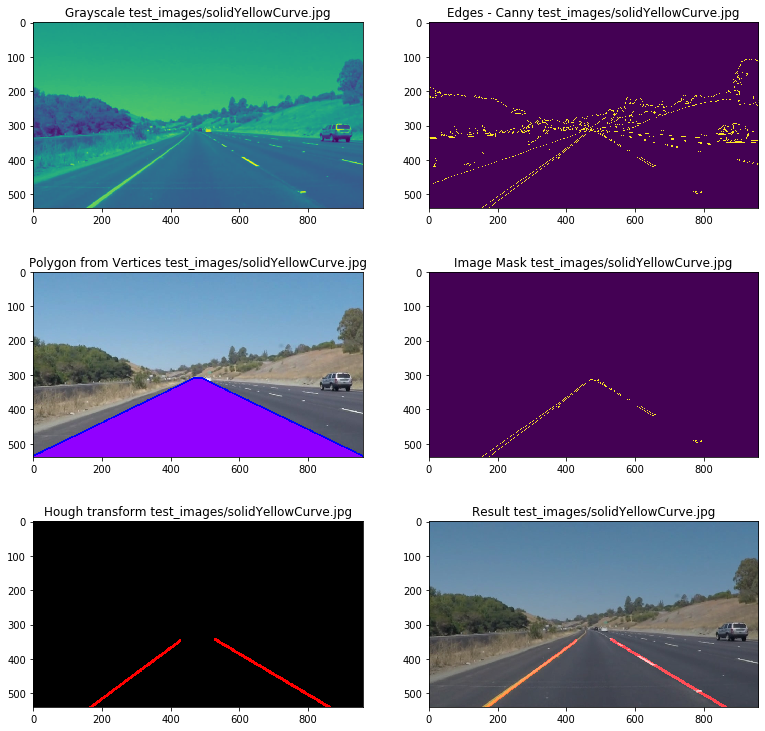

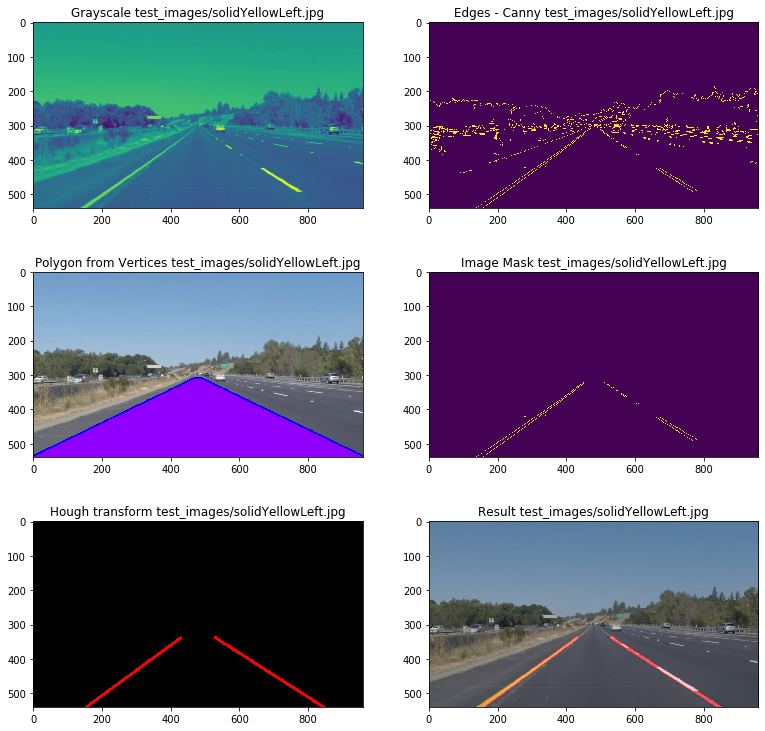

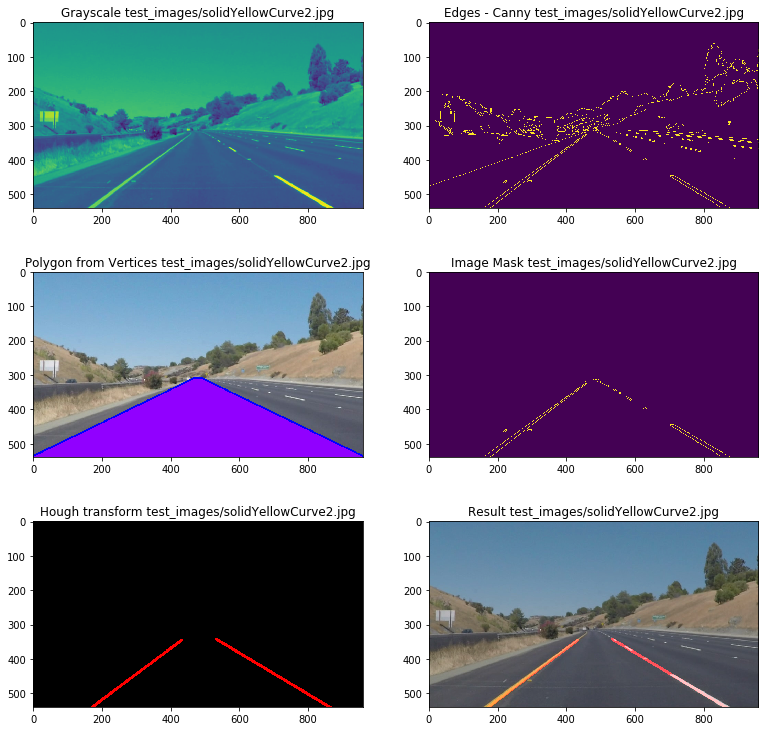

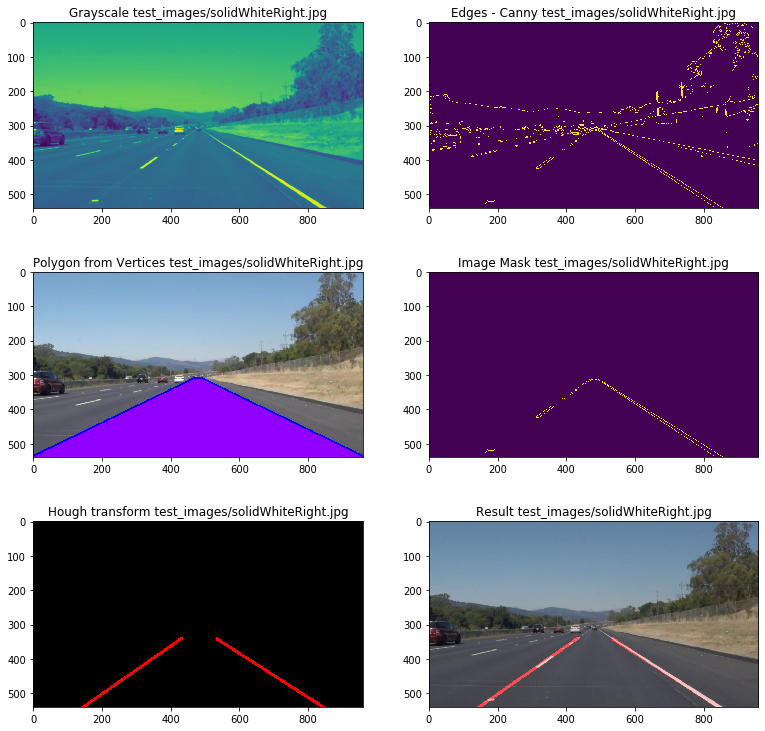

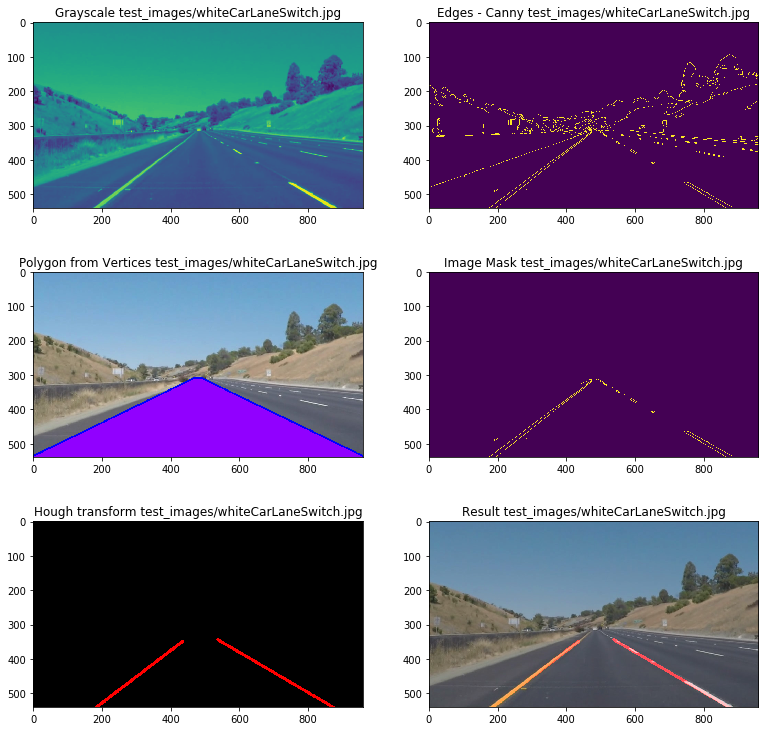

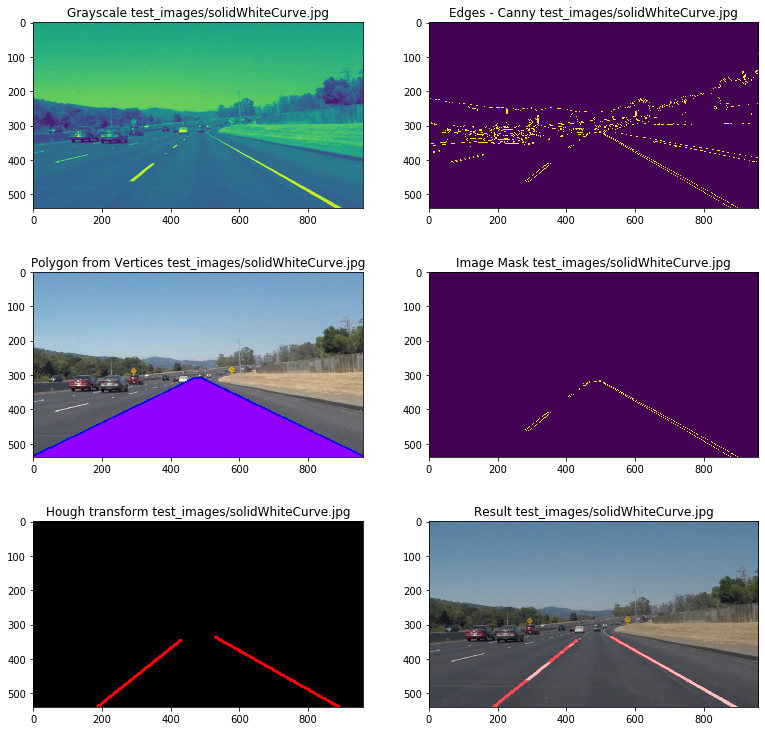

In [14]:
for file in files:
    if file[0:6] != "output":
    
        img = mpimg.imread("test_images/"+file)
        img2 = mpimg.imread("test_images/"+file)
        
        gray = grayscale(img)
        
        gray = gaussian_blur(gray,3)
       
        # Subplot of Canny transform canny(image,low_threshold,high_threshold)
        edges = canny(gray,50,150)     
        
        imshape = img.shape
        vertices = np.array([[(.51*imshape[1],imshape[0]*.58),(.49*imshape[1],imshape[0]*.58),(0,imshape[0]),(imshape[1],imshape[0])]], dtype=np.int32)

        # Subplot of the Vertices
        
        # Applies an image mask. Only keeps the region of the image defined by the polygon
        # formed from `vertices`. The rest of the image is set to black.
        target = region_of_interest(edges, vertices)
        
        lines = hough_lines(target,1,np.pi/180,35,5,2) # regression included on draw_lines function
    
        # result = image * α + lines * β + γ 
        # coefficients to help tune the lines
        
        result = weighted_img(lines,img,α=0.8, β=1.) 
        
        plot_images(file,gray,edges,vertices,img2,target,lines,result)
        # Transform color to RGB
        r, g, b = cv2.split(result)
        result = cv2.merge((b,g,r))
        cv2.imwrite("test_images/output_"+file,result)
        

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [15]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [16]:
def process_image(image):   
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    # np.pi/180 = # angular resolution (rad) for the Hough grid
    # Threshold = 35 , intersections in Hough grid cell 
    # min_line_len = 5 , min number (px) for a line
    # max_line_gap = 2, # max gap (px) between line segments
    
    gray = grayscale(image) # GrayScale image 
    gray = gaussian_blur(gray,3) # Gaussian Blur
    edges = canny(gray,50,150)   # Canny edge detection
        
    ### Hogher Transform
    imshape = img.shape 
    vertices = np.array([[(.51*imshape[1],imshape[0]*.58),(.49*imshape[1],imshape[0]*.58),(0,imshape[0]),(imshape[1],imshape[0])]], dtype=np.int32)
    target = region_of_interest(edges, vertices) # Mask edges
        
    lines = hough_lines(target,1,np.pi/180,35,5,2)  # Hough to RGB for weighted
    result = weighted_img(lines,image,α=0.8, β=1.0) # result = image * α + lines * β + γ
    
    return result

Let's try the one with the solid white lane on the right first ...

In [17]:
white_output = './test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("./test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   1%|▏         | 3/221 [00:00<00:09, 22.48it/s, now=None]

coef_slope_inter:  0.6133445010539613 11.028031882770156 -0.7397365301711997 657.5483527361065
477.81345383870905
Moviepy - Building video ./test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video ./test_videos_output/solidWhiteRight.mp4

coef_slope_inter:  0.6133445010539613 11.028031882770156 -0.7397365301711997 657.5483527361065
477.81345383870905
coef_slope_inter:  0.6273254640879752 2.5878124003941627 -0.7350606909430439 656.0992063492063
479.6814702905821


t:   3%|▎         | 7/221 [00:00<00:08, 25.11it/s, now=None]

coef_slope_inter:  0.6164792122615779 9.343391441162956 -0.7600644122383253 667.7572463768116
478.3094725202405
coef_slope_inter:  0.6171341503198211 9.51608259113259 -0.7282991202346042 651.6135386119257
477.24214204707306
negative slope is empty
coef_slope_inter:  0.6071008629176461 13.609749261647892 -0.7118650793650794 647.2940476190475
480.44022824477673
negative slope is empty
coef_slope_inter:  0.606599422504941 14.701332870228129 -0.7223809052240425 648.0721960501372
476.58407725435586
negative slope is empty
coef_slope_inter:  0.6189913997478775 7.921484570037558 -0.7239052175894282 650.5538687628161
478.5419636151809
negative slope is empty
coef_slope_inter:  0.5976802950282281 17.201919049353492 -0.7204984489195017 649.1437930490562
479.40529833392713
negative slope is empty
coef_slope_inter:  0.5975014953430745 17.805020080321277 -0.6987571651357991 640.1263887140886
480.0904230054399
coef_slope_inter:  0.6214473190547155 9.622511073681355 -0.7272727272727273 650.1818181818

t:   7%|▋         | 15/221 [00:00<00:07, 27.63it/s, now=None]

coef_slope_inter:  0.6297122004112066 5.978244744691616 -0.725 654.675
478.84469857022344
coef_slope_inter:  0.6317898737527593 6.817456826403104 -0.7197328629032259 652.8902401026393
478.0332329996803
coef_slope_inter:  0.6205811189470479 10.645255239799752 -0.7154273504273504 650.6832051282051
479.0672847965632
coef_slope_inter:  0.6416254964902789 -0.6693307023991887 -0.7264720797062085 651.0295293917441
476.3540784173903
coef_slope_inter:  0.6436045731481005 -4.859560343400072 -0.7261363636363636 654.4795454545454
481.3604442207716
coef_slope_inter:  0.6484912547894256 -9.531915305320874 -0.7179337686567164 644.0514225746269
478.3162827562994
negative slope is empty
coef_slope_inter:  0.6422913112280977 -5.729833203959158 -0.6974363951266125 640.7771739130435
482.56597519812107
negative slope is empty
coef_slope_inter:  0.6508084828687303 -10.937847599549725 -0.7101538461538462 643.9244102564103
481.17588848052293


t:   9%|▉         | 20/221 [00:00<00:06, 30.78it/s, now=None]

negative slope is empty
coef_slope_inter:  0.633891206693075 -0.5245487104292389 -0.7110119047619047 644.8850198412698
479.8929848957406
negative slope is empty
coef_slope_inter:  0.638120755209845 -0.5598122375728138 -0.6889257926757928 637.4937965075466
480.80725560208873
negative slope is empty
coef_slope_inter:  0.641373967333655 -1.2040310019671552 -0.6817308576155897 635.944212090572
481.55537722945013
coef_slope_inter:  0.6419981346244678 -1.5307491648357086 -0.7270944741532976 653.6008912655972
478.5152123604632


t:  13%|█▎        | 28/221 [00:01<00:07, 24.95it/s, now=None]

coef_slope_inter:  0.639623406332246 -0.011193747476988846 -0.7230113636363636 656.046875
481.4628858785031
coef_slope_inter:  0.6416320761176869 -2.314366005404833 -0.6886911281489595 639.3951807228915
482.3711596326285
coef_slope_inter:  0.6441624715499962 -3.456369569398229 -0.7215402506783822 654.6704354567773
481.89609225668727
coef_slope_inter:  0.6443795328293364 -4.214245563031431 -0.699933930672459 644.4156919178206
482.49902652260823
coef_slope_inter:  0.6395604302608221 -1.9345614326251166 -0.6973039215686274 642.717320261438
482.2118869516424
coef_slope_inter:  0.6386559751685925 -1.268141302503011 -0.7025258673158856 646.7425441265977
483.16392669668903


t:  17%|█▋        | 38/221 [00:01<00:05, 32.06it/s, now=None]

negative slope is empty
coef_slope_inter:  0.6443360416488284 -3.276768939204473 -0.7136857707509882 648.0076581027668
479.5831857008684
negative slope is empty
coef_slope_inter:  0.6409814951417769 -2.3578440859650756 -0.7315964975199873 655.228701066308
479.08865555759934
negative slope is empty
coef_slope_inter:  0.643060411394929 -4.086738205204426 -0.7061854441442873 644.0000821018062
480.33263741099836
negative slope is empty
coef_slope_inter:  0.6298239362263752 1.7947517421602726 -0.745124716553288 660.8205215419501
479.30936800255864
negative slope is empty
coef_slope_inter:  0.6370436543839672 -0.9121695900651474 -0.7522469986144091 662.1844082583314
477.2914698715471
coef_slope_inter:  0.6372253116842462 -0.9985468425396201 -0.7137995337995339 646.4761305361305
479.2470542218785
coef_slope_inter:  0.6365525660137332 0.36397535176483115 -0.7135102438411263 647.0341330442433
478.9926460991839
coef_slope_inter:  0.6348993843159613 2.673636312197336 -0.7074222817194704 647.54053

t:  20%|█▉        | 44/221 [00:01<00:04, 36.12it/s, now=None]

coef_slope_inter:  0.6463361421521653 -4.18085847711095 -0.7177384161211654 648.1584135541008
478.2284575829595
coef_slope_inter:  0.639509419609991 -1.6277138820696944 -0.7157149037421587 646.5816028552888
478.3040752500749
negative slope is empty
coef_slope_inter:  0.6399651721592822 -4.378512318042624 -0.7300171265932136 653.7629622913317
480.4014440249901
negative slope is empty
coef_slope_inter:  0.6495042876005045 -8.78630376982963 -0.728975653975654 652.2438034188034
479.5355284116859
negative slope is empty
coef_slope_inter:  0.6511232814924578 -9.698436933863718 -0.7178622742200328 646.0327124384236
478.9905537250253
negative slope is empty
coef_slope_inter:  0.6347852688461515 -0.5843593899044919 -0.7035090399796281 641.1966386554622
479.5514662305228
negative slope is empty
coef_slope_inter:  0.6298738260828425 0.967936093960688 -0.728030303030303 651.975
479.4204907022527
coef_slope_inter:  0.64968730953927 -8.834728689550332 -0.7959183673469388 676.7551020408164
474.257843

t:  22%|██▏       | 49/221 [00:01<00:07, 23.66it/s, now=None]

coef_slope_inter:  0.6488974348731841 -11.530913221945013 -0.7217831868602087 647.9958190974622
481.1673280135494
coef_slope_inter:  0.6503016270553215 -8.747586707005391 -0.7324749848334754 650.9329265249077
477.0694756912513
coef_slope_inter:  0.6278057423761628 2.4755087491859435 -0.7251540662503526 647.9611132850648
477.09148521651707
coef_slope_inter:  0.6493091414850654 -8.168864925356559 -0.7344859813084113 655.5732710280374
479.6534725556
coef_slope_inter:  0.6285340690547657 1.86856917758566 -0.7105438772105439 643.0066733400067
478.79072756784336


t:  26%|██▌       | 57/221 [00:02<00:07, 22.28it/s, now=None]

negative slope is empty
coef_slope_inter:  0.6377038145928924 -2.7033204360878926 -0.6945252791044182 636.6361958167483
479.90208236519527
negative slope is empty
coef_slope_inter:  0.6349476702168626 -0.295155538674976 -0.6808150183150183 630.9882783882783
479.78517663495614
negative slope is empty
coef_slope_inter:  0.6476561089988814 -6.8873503373012 -0.6694444444444444 625.9472222222222
480.475519431747
negative slope is empty
coef_slope_inter:  0.6435290071777799 -2.7184352715375297 -0.6991679179179179 639.1662912912913
478.056301884418
negative slope is empty
coef_slope_inter:  0.6381666217814804 0.6860679563600532 -0.6944577709112593 637.2966573155526
477.7119440781349


t:  29%|██▊       | 63/221 [00:02<00:06, 22.72it/s, now=None]

coef_slope_inter:  0.6315094356545761 4.113643804039754 -0.696078431372549 638.8725490196078
478.12948655292195
coef_slope_inter:  0.6504877274448023 -5.365288378840505 -0.6840796019900497 634.1666666666666
479.20546302922696
coef_slope_inter:  0.6434304539472038 -1.7367682750184485 -0.7165152573957605 647.6433729326811
477.5044590319919
coef_slope_inter:  0.6529256895065719 -8.857781189398864 -0.7001639137561468 643.4020930525785
482.0522400506046
coef_slope_inter:  0.6611700891349553 -11.579885615389767 -0.7013926568999819 643.673449086634
480.89773231274194
coef_slope_inter:  0.6547859681195687 -8.83929088297351 -0.7006003256003256 637.9957264957264
477.2329633077842


t:  30%|██▉       | 66/221 [00:02<00:07, 20.22it/s, now=None]

coef_slope_inter:  0.6590622377122404 -10.624712147637206 -0.6820709745762712 634.3825476694915
480.9419779534707
negative slope is empty
coef_slope_inter:  0.6558409158959285 -8.705679786960124 -0.6241881374127751 609.1242619431025
482.66868641227717
negative slope is empty
coef_slope_inter:  0.647188326180646 -6.021800077864725 -0.6624352658835416 624.2958064923582
481.29677136980723
negative slope is empty
coef_slope_inter:  0.6489282757173098 -4.815761486384523 -0.6825757575757575 631.6916666666667
478.0364251536251


t:  33%|███▎      | 72/221 [00:02<00:06, 22.84it/s, now=None]

negative slope is empty
coef_slope_inter:  0.650352980260367 -8.457353910783118 -0.6509175465057818 618.2941427853192
481.64580984837426
negative slope is empty
coef_slope_inter:  0.6626921698804665 -12.562577179197953 -0.6554232804232805 620.4587542087543
480.24725849475374
coef_slope_inter:  0.6566626650660263 -11.30662264905962 -0.6711229946524064 627.4705882352941
481.08458335045685
coef_slope_inter:  0.6542502731514293 -11.305999734231051 -0.675132402503611 628.8708473760231
481.55949286371833
coef_slope_inter:  0.6584213126287721 -10.854881936124718 -0.6937148217636022 637.0300187617261
479.15656139830816
coef_slope_inter:  0.6493313753553632 -7.182957690519099 -0.6632149873302394 623.6274245745902
480.60045739977323


t:  35%|███▌      | 78/221 [00:03<00:06, 21.67it/s, now=None]

coef_slope_inter:  0.6558342059048428 -9.190872169355131 -0.6753864444557875 628.5362577203817
479.05441499647355
coef_slope_inter:  0.655049623496311 -8.768499389643964 -0.663602048930611 624.1142222015677
479.9468539151192
coef_slope_inter:  0.6597118689918104 -10.352626196913548 -0.6574675324675325 621.4585497835498
479.6697969012122
negative slope is empty
coef_slope_inter:  0.6636975210287447 -11.455199921972081 -0.6582628446115288 622.237813283208
479.35855693998775


t:  37%|███▋      | 82/221 [00:03<00:06, 22.27it/s, now=None]

negative slope is empty
coef_slope_inter:  0.6784225788831053 -20.58388832658568 -0.6440145502645503 613.5623346560847
479.52844714167526
negative slope is empty
coef_slope_inter:  0.6552437788029295 -6.152184384540294 -0.6484392607617759 616.6105899256254
477.6949269188189
negative slope is empty
coef_slope_inter:  0.6640292247223526 -12.29478266773883 -0.6471701909782405 615.7933831000395
479.0180336010763
negative slope is empty
coef_slope_inter:  0.652435888444725 -6.81117773569908 -0.6540415933273076 618.3958331351188
478.544038908977
coef_slope_inter:  0.6780281004265215 -19.08518045677326 -0.6427432216905902 612.0781499202552
477.87479922361894
coef_slope_inter:  0.6579013648623155 -9.439945038417008 -0.650438284766643 616.3848614072494
478.3351223997137


t:  38%|███▊      | 85/221 [00:03<00:05, 23.25it/s, now=None]

coef_slope_inter:  0.6715539299839194 -18.982116780390285 -0.6457106812447435 617.119638351556
482.8959570534806
coef_slope_inter:  0.6751573502054189 -17.686455506408038 -0.6798220298220299 627.6244348244348
476.2514469539532
coef_slope_inter:  0.6829711909230695 -21.6575326652458 -0.6570463823984951 618.9136269065847
478.03190967415196
coef_slope_inter:  0.6866809196672063 -25.642493490158966 -0.6575804083811557 621.4742426264513
481.39206463382624


t:  41%|████      | 91/221 [00:03<00:06, 19.49it/s, now=None]

coef_slope_inter:  0.688018700141577 -24.840599809819956 -0.656871711262875 622.2347077222346
481.1360851746441
negative slope is empty
coef_slope_inter:  0.6856630251235596 -22.6924477378496 -0.655745800271056 620.7448675596213
479.6727911106329
negative slope is empty
coef_slope_inter:  0.68615737355438 -23.976926197492418 -0.6431649831649832 614.7623905723906
480.49994310351383
negative slope is empty
coef_slope_inter:  0.6917071503709666 -25.48299888098458 -0.6657157694456082 624.755059087418
479.0239272343122
negative slope is empty
coef_slope_inter:  0.6903700526453491 -25.974203971278172 -0.6344499168028579 612.5345064050946
481.9588510900196
negative slope is empty
coef_slope_inter:  0.6918600640728251 -26.78805943496881 -0.6630055772577675 625.5337712755422
481.46606631036553


t:  44%|████▍     | 98/221 [00:04<00:05, 21.17it/s, now=None]

coef_slope_inter:  0.7157127856473834 -40.601178278415695 -0.6730769230769231 630.8846153846154
483.5042983432203
coef_slope_inter:  0.6992433734973064 -32.80698473511035 -0.6568627450980392 622.4411764705883
483.18354457717845
coef_slope_inter:  0.6944850148835425 -32.96605783418128 -0.6611594202898551 623.4017391304347
484.17400605540155
coef_slope_inter:  0.6980201820100763 -34.02069026234589 -0.6596867578663695 622.9511542709358
483.8833957739565


t:  46%|████▌     | 102/221 [00:04<00:05, 22.35it/s, now=None]

coef_slope_inter:  0.7015049774878271 -36.815583365030044 -0.6620731583747087 622.6274698551019
483.61222278105765
coef_slope_inter:  0.6882924449354773 -30.959575893901288 -0.6618258548997704 622.3441941289642
483.886315815871
coef_slope_inter:  0.6830065117225541 -28.514988828741274 -0.6587566844919786 621.5026737967914
484.4503593923307
negative slope is empty
coef_slope_inter:  0.7060243388539496 -40.06538229260171 -0.6541491843889424 620.2640204043203
485.47438353496324
negative slope is empty
coef_slope_inter:  0.698316061629573 -35.14042392851814 -0.6772916666666667 631.6814583333332
484.747118342919
negative slope is empty
coef_slope_inter:  0.6905279631299998 -29.362200853779704 -0.6794285714285715 633.5628571428572
483.90225622030056
negative slope is empty
coef_slope_inter:  0.6873943437677177 -27.168968560255234 -0.6796298939156082 634.7647590504732
484.2150631743714


t:  48%|████▊     | 106/221 [00:04<00:05, 22.82it/s, now=None]

negative slope is empty
coef_slope_inter:  0.6867224791020795 -27.783637229143135 -0.6836340792862532 634.8014370492632
483.51290050938877
coef_slope_inter:  0.6906034288656624 -30.733433488096477 -0.6857764876632801 634.8621190130624
483.5841794173424
coef_slope_inter:  0.6769037208222008 -24.681945927614862 -0.6678971834837297 629.9775772491113
486.8077654324634
coef_slope_inter:  0.6737633840562798 -23.962198226230228 -0.69375 641.24375
486.4346894018068
coef_slope_inter:  0.6861351358223993 -28.52197413221242 -0.6859649122807018 635.6456140350876
484.05186566788444


t:  53%|█████▎    | 117/221 [00:04<00:04, 24.15it/s, now=None]

coef_slope_inter:  0.686100144644299 -28.88435582932838 -0.6615427266731209 628.7705006444085
488.00381055763745
coef_slope_inter:  0.6873534184033854 -29.57998941276115 -0.6692527931658366 630.550963385746
486.6046957244257
coef_slope_inter:  0.6927102337955929 -33.55986493666679 -0.6729559748427673 634.3647798742138
489.0833796618839
negative slope is empty
coef_slope_inter:  0.6805369965492358 -26.54399391250698 -0.6846640583555053 633.654009633518
483.5903116058544
negative slope is empty
coef_slope_inter:  0.6512850762850763 -11.12915442915444 -0.6504511035183304 620.9277969649398
485.54919283994246
negative slope is empty
coef_slope_inter:  0.6675923016648823 -23.643871510806974 -0.6532462560576012 621.5375734164634
488.4635152079101
negative slope is empty
coef_slope_inter:  0.6596945975711037 -17.282966782213794 -0.6738284703801946 631.1545534924845
486.2589450896397


t:  55%|█████▍    | 121/221 [00:04<00:03, 27.09it/s, now=None]

negative slope is empty
coef_slope_inter:  0.6638275720025191 -17.243081038416083 -0.6372326861723978 615.1966570506602
486.09565476716756
coef_slope_inter:  0.6515393807545218 -11.687951497796496 -0.6363636363636364 614.3636363636364
486.10149952307785
coef_slope_inter:  0.6532747948595911 -10.804287943675945 -0.6606269772792637 622.1082830025885
481.7046330000516
coef_slope_inter:  0.6533355782135581 -12.301153096003631 -0.7123756218905473 646.2182835820895
482.18059325272833
coef_slope_inter:  0.645626702459731 -5.848150530382031 -0.6976850441669205 643.252208346025
483.2090246411076


t:  57%|█████▋    | 127/221 [00:05<00:03, 24.42it/s, now=None]

coef_slope_inter:  0.6181710455598552 8.849361672977874 -0.6797465359659361 634.3717976588234
481.94311017075586
coef_slope_inter:  0.6485421562613933 -9.898977893618564 -0.6691053614428227 630.1121861025111
485.7225892333056
coef_slope_inter:  0.6495054035884215 -8.01301706448161 -0.6726778656126482 632.3364624505929
484.3121936507381
coef_slope_inter:  0.6449707426565208 -6.396154298627526 -0.6538461538461539 623.0
484.59190513566847
negative slope is empty
coef_slope_inter:  0.6604409105242012 -14.70868052069818 -0.6839999999999999 636.612
484.45467214081316
negative slope is empty
coef_slope_inter:  0.6430837047774228 -4.671560606251688 -0.6615485089623021 627.3790812635641
484.46653027066094
negative slope is empty
coef_slope_inter: 

t:  59%|█████▉    | 130/221 [00:05<00:04, 21.34it/s, now=None]

 0.6397525333037601 -2.8648325778602386 -0.6781436349451057 636.048594466793
484.79800035658326
negative slope is empty
coef_slope_inter:  0.634654719798202 -1.1584744923266386 -0.6870094191522763 639.6488749345891
484.8488587545207
coef_slope_inter:  0.6400403919929175 -4.417662879533093 -0.6698717948717949 631.801282051282
485.69587435751043
coef_slope_inter:  0.6370338113308746 -1.4747214527579426 -0.689792008757526 641.7969348659003
484.8199715285914
coef_slope_inter:  0.6244285181858327 4.2913979663614015 -0.6890340973885278 641.8227186680351
485.38215944797895
coef_slope_inter:  0.6455698096150619 -4.700902447422538 -0.7160139324667564 652.883212871657
482.95532253760194


t:  62%|██████▏   | 138/221 [00:05<00:03, 24.09it/s, now=None]

coef_slope_inter:  0.6376143252341812 -2.535592800670244 -0.7021471442537939 646.9697722629185
484.7917930583675
coef_slope_inter:  0.6374710307628358 -5.075931987128724 -0.6992110404555681 644.6740625777479
486.091650778723
coef_slope_inter:  0.6370440952894199 -4.535224296117765 -0.6997405899360452 643.9808213001046
485.131265164698
negative slope is empty
coef_slope_inter:  0.6234636648880835 0.322117562669888 -0.7013105238628284 643.0937689426371
485.1933686796967
negative slope is empty
coef_slope_inter:  0.6327637856990673 -2.8313890883268624 -0.6887676366843034 637.8784722222222
484.8237813029328
negative slope is empty
coef_slope_inter:  0.6277393942445928 0.6477568111251457 -0.690179638163509 638.2874103942652
483.8230861709651
negative slope is empty
coef_slope_inter:  0.6373221720840102 -3.011576445642703 -0.7232068585009762 654.5386979034038
483.30484654658176


t:  66%|██████▌   | 146/221 [00:05<00:02, 25.00it/s, now=None]

negative slope is empty
coef_slope_inter:  0.6393188337504034 -3.047497034377682 -0.7122307457833773 649.6969010363747
482.960009721521
negative slope is empty
coef_slope_inter:  0.6340130244313442 -0.14101085740791014 -0.7035155458757943 648.2327533543062
484.75507634414646
coef_slope_inter:  0.6392537518265639 -2.165796830401166 -0.7135290556900726 652.3639527845037
483.8394943948572
coef_slope_inter:  0.6372829746210988 -1.4294991398058319 -0.7555970149253731 669.6473880597015
481.79088811377994
coef_slope_inter:  0.6380824372759857 -2.9068324372759946 -0.7162532768703368 652.2721516434766
483.7640898318414


t:  67%|██████▋   | 149/221 [00:06<00:02, 25.84it/s, now=None]

coef_slope_inter:  0.6327015142934803 -2.4541831550036193 -0.7399986076301865 662.3123503202451
484.27658951735356
coef_slope_inter:  0.6203854702251499 3.328809634555671 -0.7265031623131684 655.359793953317
484.1016313946887
coef_slope_inter:  0.6218907022857928 0.3365561281057694 -0.7529411764705882 666.5
484.541749551574
coef_slope_inter:  0.6313658522388849 -2.2175792323502037 -0.6923076923076923 642.5384615384615
487.09596367408875
negative slope is empty
coef_slope_inter:  0.6273033541877405 -0.17444270598800976 -0.739782608695652 662.5220652173913
484.7511611674012


t:  70%|███████   | 155/221 [00:06<00:02, 24.90it/s, now=None]

negative slope is empty
coef_slope_inter:  0.6235767616382407 2.2590007277961015 -0.7362588522588522 660.3904615384615
483.9786913100146
negative slope is empty
coef_slope_inter:  0.6156485809073319 6.931007558524574 -0.7168856961644308 653.3275399359305
485.0881088011177
negative slope is empty
coef_slope_inter:  0.635759092339863 -5.428197298492563 -0.7292231782069181 657.4296497389992
485.61645183271565
negative slope is empty
coef_slope_inter:  0.6251072764435074 -0.3709193407272551 -0.7308059384941675 657.5260273064687
485.2057929662087
coef_slope_inter:  0.6315976858997451 -5.070254320671306 -0.740909090909091 661.4227272727272
485.60268907599595
coef_slope_inter:  0.6290093084451869 -3.654816536077226 -0.7500510308226169 667.7675035721576
486.86942912499296
coef_slope_inter:  0.6093592776890236 7.919955997493779 -0.7271148103223244 657.0713881263478
485.7194299178527


t:  73%|███████▎  | 162/221 [00:06<00:02, 27.68it/s, now=None]

coef_slope_inter:  0.624609785179023 -0.8683826326594613 -0.7215416003828296 654.6471921519937
486.95531707309135
coef_slope_inter:  0.6215235637152919 3.173851135146606 -0.7457908728400532 662.1609437306158
481.95724039573923
coef_slope_inter:  0.606003361889745 9.155331325275748 -0.7497447877162966 664.6095489081545
483.4631105883074
coef_slope_inter:  0.6090347399614046 8.424307943974473 -0.7 649.3
489.578826666526
negative slope is empty
coef_slope_inter:  0.6013258912592215 13.39414128879553 -0.7613327848621966 674.5758535582065
485.2144736283888
negative slope is empty
coef_slope_inter:  0.5805956241229706 25.126001379566247 -0.7601526965562053 673.2616494941057
483.41335813586306
negative slope is empty
coef_slope_inter:  0.5747985306432376 28.79480391203698 -0.7565526321763411 672.5260595673197
483.51725197127394


t:  77%|███████▋  | 170/221 [00:06<00:01, 28.57it/s, now=None]

negative slope is empty
coef_slope_inter:  0.587680453354082 22.155235089246844 -0.7711154421680737 678.3374219486062
482.9144605321337
negative slope is empty
coef_slope_inter:  0.5886763000564638 22.210499692974807 -0.7745602848185343 680.4096830331049
482.82095026116366
coef_slope_inter:  0.5853904046072823 24.65753586549924 -0.758888888888889 675.3866666666668
484.07286636749865
coef_slope_inter:  0.593176110198898 20.525610096631112 -0.8 692.6
482.4044749141009
coef_slope_inter:  0.5897731818997899 20.87228626198625 -0.7831325301204819 687.6987951807229
485.70451931289693
coef_slope_inter:  0.5827407293581235 26.09079321812034 -0.7805555555555556 681.9333333333334
481.07117093533316


t:  79%|███████▊  | 174/221 [00:06<00:01, 29.17it/s, now=None]

coef_slope_inter:  0.5905411669515779 22.331565769792746 -0.8041095890410959 693.9328767123288
481.555190829484
coef_slope_inter:  0.5727476335681003 31.388958183172644 -0.7692307692307693 686.0
487.7955117992595
negative slope is empty
coef_slope_inter:  0.5867761501658053 23.857491525720217 -0.7923464707520435 687.1805043654889
480.9746448784276
negative slope is empty
coef_slope_inter:  0.5885826610364538 23.238257426540184 -0.7861471861471863 685.3564935064936
481.6351644917083
negative slope is empty
coef_slope_inter:  0.575178009604239 29.20059612518628 -0.7702838827838827 677.3833333333333
481.75480916643266


t:  81%|████████▏ | 180/221 [00:07<00:01, 23.72it/s, now=None]

negative slope is empty
coef_slope_inter:  0.6078500907329951 12.012874543177572 -0.7693721166627571 678.1025295175541
483.64719316711694
negative slope is empty
coef_slope_inter:  0.588646570225965 22.313950504315557 -0.7902937521810071 688.5146073833573
483.1250823938292
negative slope is empty
coef_slope_inter:  0.590301387137795 22.52898378038701 -0.7827777777777778 683.9551587301587
481.7101532455641
coef_slope_inter:  0.5881502601040416 23.01431072428973 -0.7843841126194068 684.5430467571645
481.9760795645778
coef_slope_inter:  0.5805295099978723 24.423930460235283 -0.7975623167155425 688.2674120234605
481.71208093325174
coef_slope_inter:  0.5900726502101659 20.67225839351958 -0.796886988350403 688.0702319360856
481.1949497212573


t:  85%|████████▍ | 187/221 [00:07<00:01, 23.85it/s, now=None]

coef_slope_inter:  0.5908664025006203 19.231074075307834 -0.8096590909090909 693.7994318181818
481.65375133627435
coef_slope_inter:  0.5846463948931668 24.534692936586783 -0.7910836485726295 686.6811898965965
481.3055439945927
coef_slope_inter:  0.5920143774275529 19.309695333917716 -0.7970695970695971 690.3139194139194
483.0551906143083
coef_slope_inter:  0.5917213521197184 19.405961888073318 -0.7843137254901961 679.3921568627451
479.6289031534181
negative slope is empty
coef_slope_inter:  0.5977367434878007 14.409585552188869 -0.8013522910262041 689.9122749231445
482.8160843999481


t:  86%|████████▌ | 190/221 [00:07<00:01, 21.84it/s, now=None]

negative slope is empty
coef_slope_inter:  0.5833844409634755 23.06837543479502 -0.8014472455648927 690.1782212885153
481.726300996258
negative slope is empty
coef_slope_inter:  0.5831888827245384 21.527010577181997 -0.7722222222222223 675.8539682539682
482.75165762529855
negative slope is empty
coef_slope_inter:  0.5810104478854479 21.036599442224443 -0.7467900714876521 664.5957694523219
484.68061325502697
negative slope is empty
coef_slope_inter:  0.5704996427967356 26.42724911176242 -0.8007553606237816 683.7576754385965
479.36410418715764
coef_slope_inter:  0.5786891532055458 22.106247525883045 -0.7940251572327044 684.1383647798742
482.27960633894173


t:  87%|████████▋ | 193/221 [00:07<00:01, 21.13it/s, now=None]

coef_slope_inter:  0.5675348138477869 31.56393962256527 -0.7424242424242424 664.6212121212121
483.2649306614547
coef_slope_inter:  0.5552950154420742 41.72460119945416 -0.7745806756437514 681.1785022442713
480.83734843119936
coef_slope_inter:  0.5710899095955778 30.553272231300117 -0.7654725756140851 678.0392925852832
484.44126445193


t:  90%|████████▉ | 198/221 [00:08<00:01, 16.53it/s, now=None]

coef_slope_inter:  0.5817842012411496 25.02230774152546 -0.787833081950729 686.5935143288084
483.03362896056495
coef_slope_inter:  0.5727998315535869 32.61126078203038 -0.7828273182297155 686.0295607218125
482.00443613439825
coef_slope_inter:  0.586869806660384 22.892699594522252 -0.7599039615846338 673.7629051620648
483.2810238171569
negative slope is empty
coef_slope_inter:  0.5830168384485113 24.390652257024236 -0.805952380952381 693.5559523809525
481.7711514244794
negative slope is empty
coef_slope_inter:  0.5855974414215724 23.146353023058875 -0.7450149850149851 666.2565434565435
483.31894220750956


t:  91%|█████████▏| 202/221 [00:08<00:01, 18.41it/s, now=None]

negative slope is empty
coef_slope_inter:  0.5807508132641084 26.035052051343794 -0.807830264973122 694.3674254317111
481.30597763063207
negative slope is empty
coef_slope_inter:  0.5776047202260632 28.05067147791944 -0.7717865467865468 680.8033522033522
483.7386284339521
negative slope is empty
coef_slope_inter:  0.551701008046645 41.40040162177862 -0.7766499582289056 679.9063074352549
480.6756060890506
coef_slope_inter:  0.5805927845975449 24.167465650186188 -0.7592592592592593 671.5740740740741
483.19261174562877
coef_slope_inter:  0.5667020714124307 34.04529477068199 -0.7782258064516129 682.9233870967741
482.4631141980732
coef_slope_inter:  0.5713925728096785 29.313265444908637 -0.765625 672.296875
480.9088695849315


t:  95%|█████████▌| 210/221 [00:08<00:00, 21.11it/s, now=None]

coef_slope_inter:  0.5718011777774185 30.65370114631625 -0.8109235352532274 697.6719960278053
482.39413716669844
coef_slope_inter:  0.5674328236927315 32.15703546337706 -0.7816430291677816 683.3010436178754
482.6593010125006
coef_slope_inter:  0.5714226366315971 29.51842458362438 -0.7968728847976174 687.2255313388384
480.676210990024
coef_slope_inter:  0.564430855694888 32.76806244712397 -0.7547169811320755 671.5849056603773
484.26478471877965
negative slope is empty
coef_slope_inter:  0.5657692941362532 32.953960240700106 -0.8151820728291316 694.1423529411766
478.7919462749987


t:  97%|█████████▋| 214/221 [00:08<00:00, 22.85it/s, now=None]

negative slope is empty
coef_slope_inter:  0.5627056108453317 34.57042564687603 -0.8127786253072293 696.6036867531147
481.30923183681597
negative slope is empty
coef_slope_inter:  0.5507587127702208 41.67062138160199 -0.801119321291735 690.0098508483852
479.5841141961111
negative slope is empty
coef_slope_inter:  0.5519751531263828 39.91572418199341 -0.7703159041394335 678.2893790849672
482.778471044778
negative slope is empty
coef_slope_inter:  0.5656966682040389 35.344636057052796 -0.7984138412828535 688.7333198991578
478.98515501348635
coef_slope_inter:  0.5652680351546774 35.7317769980558 -0.7942307692307693 687.7403846153846
479.5948370929723
coef_slope_inter:  0.5682612139855642 35.64636017451795 -0.85 711.05
476.219495509913
coef_slope_inter:  0.5666042464519035 35.83343658481644 -0.8053173241852487 691.6277873070326
478.0115458186506


coef_slope_inter:  0.5665710959949682 36.20453332718837 -0.8081774876499648 691.2523376852505
476.485527718315
coef_slope_inter:  0.5489902871717793 44.10003416000545 -0.7978946613088405 687.9522588978186
478.0306034781393
coef_slope_inter:  0.5708447962761616 34.099075266165414 -0.7857680722891567 684.0406626506024
479.09142132182535
coef_slope_inter:  0.5620415405309582 38.19862398847927 -0.7450980392156863 668.3921568627451
482.11647986086734
Moviepy - Done !
Moviepy - video ready ./test_videos_output/solidWhiteRight.mp4
CPU times: user 3.7 s, sys: 513 ms, total: 4.22 s
Wall time: 10.4 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [18]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [19]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

t:   1%|          | 6/681 [00:00<00:13, 49.80it/s, now=None]

coef_slope_inter:  0.6880638274255296 -30.091667670391075 -0.6210776766751991 611.4229829101349
490.0269746021025
Moviepy - Building video test_videos_output/solidYellowLeft.mp4.
Moviepy - Writing video test_videos_output/solidYellowLeft.mp4

coef_slope_inter:  0.6880638274255296 -30.091667670391075 -0.6210776766751991 611.4229829101349
490.0269746021025
coef_slope_inter:  0.6791429690345454 -23.876335720254147 -0.6225918606353389 612.5895776606646
488.93668577825827
coef_slope_inter:  0.6742328467992185 -20.514883346741726 -0.6267884409557387 612.7042450341926
486.7092755058739
coef_slope_inter:  0.6689655172413793 -16.724137931034505 -0.6373460092246065 617.0202303506022
485.14030186668367
positive slope is empty
coef_slope_inter:  0.6584498834498834 -13.817199467199439 -0.6399107664672011 619.5031492188181
487.7846141797831
positive slope is empty
coef_slope_inter:  0.6668376068376068 -18.74991452991452 -0.6378485942047458 619.7410978692669
489.382820090434
positive slope is empty
c

t:   3%|▎         | 18/681 [00:00<00:13, 50.98it/s, now=None]

positive slope is empty
coef_slope_inter:  0.6603767356674334 -15.52961495868472 -0.6755577590765905 635.6794835138305
487.4558603244183
coef_slope_inter:  0.6111111111111112 11.666666666666629 -0.6760645491304912 636.1935402428358
485.19164311959236
coef_slope_inter:  0.6153846153846154 8.615384615384585 -0.6634651394499095 627.8129577942628
484.1832051326456
coef_slope_inter:  0.6300675675675675 -1.5743243243243228 -0.6497349660414291 623.913726221796
488.73793739278415
coef_slope_inter:  0.6 19.400000000000034 -0.677004426708587 635.1463875117856
482.18030778392847
coef_slope_inter:  0.6222002635046113 4.113636363636374 -0.6616601980849991 629.2599970634191
486.9270293796247
coef_slope_inter:  0.6497439180537772 -12.157298335467374 -0.6673116202851406 632.8627244795196
489.7439812056005
coef_slope_inter:  0.6111888111888112 11.639160839160846 -0.701769619715991 645.1221509765915
482.48518401369114
coef_slope_inter:  0.6521226415094339 -15.166273584905639 -0.6816929343417728 636.8197

t:   5%|▍         | 32/681 [00:00<00:11, 56.43it/s, now=None]

positive slope is empty
coef_slope_inter:  0.6378400383141762 -4.7857854406130285 -0.681848827000609 638.6762021233056
487.58613069788515
positive slope is empty
coef_slope_inter:  0.6042635658914729 13.632170542635663 -0.6886455338433431 638.4396018029627
483.257045207957
coef_slope_inter:  0.5961538461538461 18.0 -0.6834847982440702 634.8430048714528
482.0446831391874
coef_slope_inter:  0.6166666666666667 5.416666666666629 -0.7113989116229682 646.5126460188135
482.7291587346085
coef_slope_inter:  0.632034632034632 -1.4264069264069121 -0.6777188987553907 634.453335194083
485.4957266173104
coef_slope_inter:  0.6229276895943563 5.144444444444474 -0.6814923924842603 635.3913623258816
483.1625383113754
coef_slope_inter:  0.6300847457627119 0.8169491525423496 -0.7198741632914343 653.358993737036
483.37919043898876
coef_slope_inter:  0.6213544795546478 6.719616324242054 -0.6951584800890368 645.9364701003992
485.53783621633454
coef_slope_inter:  0.5925925925925926 20.666666666666686 -0.70565

t:   5%|▌         | 37/681 [00:00<00:14, 44.15it/s, now=None]

positive slope is empty
coef_slope_inter:  0.6208304577869795 2.421785139176469 -0.6966072871047738 642.0686512839122
485.52340983466513
positive slope is empty
coef_slope_inter:  0.5857142857142856 23.97142857142859 -0.733404651753804 656.5342524479405
479.5343360702939
coef_slope_inter:  0.6154083204930663 4.640986132511557 -0.7343585717516833 655.0441388052437
481.86331759187675
coef_slope_inter:  0.6081912878787878 9.822443181818159 -0.7283566062972042 653.8545062329384
481.8623154901446
coef_slope_inter:  0.6144736842105263 5.126315789473665 -0.7355464074685346 654.652588726645
481.1234121185084
coef_slope_inter:  0.591157476403378 17.460506706408324 -0.7456169876746662 657.7963155834793
479.01559020182384
coef_slope_inter:  0.6080208202684059 8.897184246833064 -0.7347463148822296 653.7819133410954
480.26549966306516


t:   6%|▋         | 43/681 [00:00<00:13, 47.28it/s, now=None]

coef_slope_inter:  0.5871046653852874 19.024899528219464 -0.7605663525184276 664.1994416548273
478.7329649116952
coef_slope_inter:  0.6016907452995753 12.873099165633448 -0.7382049121240065 653.7460942640276
478.3006733007082
coef_slope_inter:  0.58312447786132 23.39055973266497 -0.7425125503114167 656.4003186695751
477.5136372053919
positive slope is empty
coef_slope_inter:  0.5938940092165899 16.70967741935482 -0.7340633296518568 650.3655938219998
477.16586810129286
positive slope is empty
coef_slope_inter:  0.6213235294117647 0.8860294117646959 -0.7584476745892942 663.1149842616941
479.9556280994983
positive slope is empty
coef_slope_inter:  0.6257631257631258 0.557387057387056 -0.7383076194174812 655.0398415169569
479.80096103660264
positive slope is empty
coef_slope_inter:  0.6325642442663719 -3.274339136041268 -0.7615336822325232 665.1748347692312
479.48509297621587
coef_slope_inter:  0.6 14.199999999999989 -0.7304589253626762 652.8903957526469
480.05269728905256


t:   8%|▊         | 52/681 [00:01<00:19, 32.08it/s, now=None]

coef_slope_inter:  0.6225806451612903 2.8645161290322676 -0.7326201303648947 653.8327552876287
480.34818966646804
coef_slope_inter:  0.610252079002079 11.384507103257116 -0.7493237236157311 660.2175091114048
477.2319430507995
coef_slope_inter:  0.6128757701045265 9.013023340696142 -0.73527815546239 651.8047840506777
476.79404296484853
coef_slope_inter:  0.6067593607042633 11.863151837542759 -0.7354209666857247 651.5573882139038
476.6082644202619
coef_slope_inter:  0.6095085470085471 10.06463675213675 -0.7265840488102819 650.1207060913309
479.0506820726251
coef_slope_inter:  0.6201550387596899 7.52713178294573 -0.7274030880745802 650.6046637707294
477.21691493822505
coef_slope_inter:  0.6229694218824653 5.238174868609661 -0.7291771269869096 650.707569275159
477.3664474063642


t:   9%|▉         | 60/681 [00:01<00:20, 30.65it/s, now=None]

positive slope is empty
coef_slope_inter:  0.6042783274926132 15.426716141001847 -0.7326842911152801 652.7227820804895
476.6745584877081
positive slope is empty
coef_slope_inter:  0.6 16.600000000000023 -0.7490756118881118 660.783187541625
477.49969079942986
positive slope is empty
coef_slope_inter:  0.6063289440898549 13.393191880857913 -0.7313285302159142 649.7102795005561
475.6950862551271
positive slope is empty
coef_slope_inter:  0.6194444444444445 7.213888888888931 -0.739392037302726 655.9989969768395
477.45635093175673
positive slope is empty
coef_slope_inter:  0.6218885281385281 5.20955086580085 -0.7260398350008382 649.1118234458219
477.69769535849287
coef_slope_inter:  0.6198257080610021 6.753812636165577 -0.7545979160726056 662.3135871318184
476.970682826335
coef_slope_inter:  0.5740740740740741 34.46296296296299 -0.7157517665605908 647.2858069146151
475.12061291167015


t:  10%|▉         | 68/681 [00:01<00:20, 29.57it/s, now=None]

coef_slope_inter:  0.6438356164383562 -5.9178082191780845 -0.7063509111557523 639.7122775460281
478.17843873442547
coef_slope_inter:  0.6160202912780233 8.77581410571102 -0.7138966086727109 643.8931547903467
477.56167374680564
coef_slope_inter:  0.6114384007083861 13.867224224090611 -0.7266699832059503 650.5434428793803
475.80317581811727
coef_slope_inter:  0.6101694282728766 13.594995521719653 -0.6991522165992271 639.073921294071
477.712201751197
coef_slope_inter:  0.6125046451133408 11.8840951319212 -0.7146147903156811 645.7149553111688
477.59895850997555
coef_slope_inter:  0.6110973187686197 13.772715988083405 -0.708498184971589 642.7701529766344
476.6592756687529
positive slope is empty
coef_slope_inter:  0.6098833265499932 15.509469542802861 -0.695158594857905 637.8298947129505
476.85857056513504


t:  11%|█         | 76/681 [00:02<00:20, 29.89it/s, now=None]

coef_slope_inter:  0.6363636363636364 5.363636363636374 -0.7163063909774436 644.5029605263157
472.5020228466395
positive slope is empty
coef_slope_inter:  0.582051282051282 28.715384615384608 -0.7150546292787672 648.3666808765947
477.7183504050345
positive slope is empty
coef_slope_inter:  0.6327851106920874 1.6035442419163342 -0.7268728478118905 652.0638586722274
478.3999610799234
positive slope is empty
coef_slope_inter:  0.6179393939393939 9.042060606060591 -0.7168246412738625 647.8589099193233
478.5990875242593
coef_slope_inter:  0.6269230769230769 5.026923076923083 -0.7043221088145168 642.6392370429483
478.9593388183768
coef_slope_inter:  0.6208955223880597 9.394029850746307 -0.7174851292374622 649.2522060490396
478.08385112348833
coef_slope_inter:  0.630846809250565 3.0533820205181996 -0.7086507567122028 645.3301174661133
479.49078204106826


t:  12%|█▏        | 80/681 [00:02<00:20, 29.71it/s, now=None]

coef_slope_inter:  0.6280806572068709 5.672516803584756 -0.7205648243576052 650.0953152990301
477.82965004850064
coef_slope_inter:  0.6216102344109085 9.953079515857212 -0.7184091435056149 650.8926734459816
478.30621294944575
coef_slope_inter:  0.6505818619582664 -6.904293739967898 -0.7307031693854456 654.8051030646886
479.05347686345857
coef_slope_inter:  0.6282906933629959 4.681497960697072 -0.7036048241323275 643.9664926546388
479.9813395994754
coef_slope_inter:  0.5961538461538461 25.30769230769232 -0.7286315271337996 652.5915808454096
473.49850110514274
positive slope is empty
coef_slope_inter:  0.6322557471264367 1.2739224137931047 -0.7082446271448534 644.1331219325169
479.5665945771845


t:  12%|█▏        | 84/681 [00:02<00:22, 26.83it/s, now=None]

positive slope is empty
coef_slope_inter:  0.6240196078431373 9.029411764705875 -0.6977179423589218 639.0535735964031
476.6635870603684
positive slope is empty
coef_slope_inter:  0.6282894736842105 2.0953947368421098 -0.7127839264463472 646.6656287727703
480.63755046754136
positive slope is empty
coef_slope_inter:  0.6425925925925925 -4.438888888888869 -0.7031871292371619 640.1640310254104
478.9810022088025
coef_slope_inter:  0.6168763102725368 9.232180293501045 -0.7186868686868687 647.1124579124579
477.61145834819786


t:  13%|█▎        | 90/681 [00:02<00:24, 24.37it/s, now=None]

coef_slope_inter:  0.6393034825870647 -1.7860696517412862 -0.720804144784602 647.5510878115458
477.4160106124068
coef_slope_inter:  0.6306394027913016 3.667315806556303 -0.6872046825438576 634.0266676308429
478.32619870503964
coef_slope_inter:  0.6261892177589852 7.3008720930232585 -0.6887955383418463 634.9535170652505
477.30792471947075
coef_slope_inter:  0.6235978396343997 3.8574989613626656 -0.688883132332645 634.5175512898462
480.5098632274258
coef_slope_inter:  0.6285659704533877 6.03871625063681 -0.6834870017574 633.6784026058552
478.36459323563423
coef_slope_inter:  0.6118055555555556 13.882638888888835 -0.6855682674813111 634.0186589449198
477.99331930748303


t:  14%|█▍        | 94/681 [00:02<00:23, 25.08it/s, now=None]

coef_slope_inter:  0.6022727272727273 22.659090909090878 -0.6989944993721149 641.3508224411468
475.45324961981606
positive slope is empty
coef_slope_inter:  0.6440341098826372 -1.6145983049208676 -0.6877004585655501 638.2653986355397
480.4861359768449
positive slope is empty
coef_slope_inter:  0.6585057261579 -9.732087970000999 -0.6884201639782827 639.0591633627006
481.6829612408034
positive slope is empty
coef_slope_inter:  0.6481207178211787 -3.597261843805622 -0.695117926064492 643.5377051600606
481.77214819539313


t:  15%|█▍        | 101/681 [00:03<00:24, 23.22it/s, now=None]

positive slope is empty
coef_slope_inter:  0.6454981992797119 -1.1875150060023998 -0.6975005618622641 644.2880980035236
480.6226421688331
positive slope is empty
coef_slope_inter:  0.6371436287384563 1.9167261501313178 -0.6872420847591822 637.9264049985824
480.22994537503746
positive slope is empty
coef_slope_inter:  0.6423135501782917 -1.7575255924419935 -0.6893345187611549 639.8494473962112
481.8142180010391
coef_slope_inter:  0.6436781609195402 -1.9425287356321803 -0.7212809852797633 653.1326584831723
479.92292592994147
coef_slope_inter:  0.6428571428571428 -2.261904761904759 -0.7067998200507444 645.5316469567966
479.9690362231048


t:  16%|█▌        | 107/681 [00:03<00:23, 24.53it/s, now=None]

coef_slope_inter:  0.6550144300144299 -9.200036075036072 -0.6993057397052325 646.7891272266098
484.3678606938509
coef_slope_inter:  0.6457378388942189 -3.1562022527804365 -0.7131990472943662 649.7333845251684
480.44143433997914
coef_slope_inter:  0.6394830659536541 -0.8159536541889167 -0.6979337966429895 641.9291274360496
480.58694268466564
coef_slope_inter:  0.648 -1.7839999999999918 -0.7064190487102543 645.8396318983577
478.15602749758824
coef_slope_inter:  0.6666666666666666 -16.66666666666663 -0.6818787166204479 633.5680679686435
482.17489948343155
positive slope is empty
coef_slope_inter:  0.6304024327122153 4.3922424948240035 -0.6856924589129608 635.7651241031165
479.7320357566645


t:  16%|█▌        | 110/681 [00:03<00:23, 23.91it/s, now=None]

positive slope is empty
coef_slope_inter:  0.6273148148148149 3.824074074074076 -0.6891799046585813 636.8027719675157
480.8061046736565
positive slope is empty
coef_slope_inter:  0.6258349625285108 6.864898989898999 -0.6846994399351943 635.182480663316
479.4361601589609
positive slope is empty
coef_slope_inter:  0.6335220335220334 2.448129648129655 -0.6831992836699357 636.8798428625876
481.826871738845
positive slope is empty
coef_slope_inter:  0.6252930622009569 6.942218899521538 -0.6965709819672341 643.9560656450844
481.90572211714584
positive slope is empty
coef_slope_inter:  0.6249299719887956 7.350630252100847 -0.6799035083135561 635.0210058992493
481.0348486012996
coef_slope_inter:  0.6416666666666666 -1.3166666666666629 -0.7093742261876363 647.5482682293074
480.2703888001028
coef_slope_inter:  

t:  17%|█▋        | 117/681 [00:03<00:21, 25.78it/s, now=None]

0.6282756813417191 7.046907756813425 -0.6912882471059563 640.0052092341729
479.67232798032506
coef_slope_inter:  0.6269097222222222 7.885763888888874 -0.7058431460312422 646.992693113854
479.5389636358442
coef_slope_inter:  0.633633846995916 4.257883878573542 -0.7069587513966402 648.4884437596302
480.55655435777004
coef_slope_inter:  0.6339367421642644 3.5291075650118082 -0.7235751775303471 653.425365654259
478.74073786066583


t:  18%|█▊        | 124/681 [00:03<00:20, 27.37it/s, now=None]

coef_slope_inter:  0.6143739852776595 15.299372645450111 -0.7136170451491741 650.5750898446265
478.37350000398004
coef_slope_inter:  0.6311283345349676 3.7639689978370257 -0.7102402578057831 648.4008296059259
480.5814481485417
positive slope is empty
coef_slope_inter:  0.6382178667892954 -1.4505248719534538 -0.7006431721379952 644.4832355821247
482.4501883866955
positive slope is empty
coef_slope_inter:  0.6235560675883256 6.379854070660519 -0.702526033363507 646.4340109070148
482.665557718438
positive slope is empty
coef_slope_inter:  0.608621015973957 14.31351729881143 -0.7032444112931601 645.8846946526755
481.42985113157187
positive slope is empty
coef_slope_inter:  0.5918826135105205 26.45205980066446 -0.7006439393939393 645.0548556998557
478.599680996199
coef_slope_inter:  0.5961538461538461 22.576923076923094 -0.7040675553358028 645.3470001838306
478.97233224542134
coef_slope_inter:  0.6666666666666666 -15.666666666666629 -0.7091607960287735 647.7243248766423
482.1760064620548


t:  19%|█▉        | 130/681 [00:04<00:19, 27.63it/s, now=None]

coef_slope_inter:  0.6376811594202898 2.797101449275374 -0.7216123520221189 651.8033259944823
477.45848787030303
coef_slope_inter:  0.6436781609195402 -1.0344827586206975 -0.7019573333759148 642.9091754177668
478.5424142765662
coef_slope_inter:  0.6333740333740333 4.083394383394345 -0.7267061253088468 657.583886860641
480.4867480091065
coef_slope_inter:  0.6237859362859363 9.126068376068389 -0.6969541421781462 643.9910064051934
480.68878076860005
coef_slope_inter:  0.635431089684648 2.5795414057909767 -0.6900651230422414 640.5808541512966
481.33016648381926
coef_slope_inter:  0.6134366925064599 16.675452196382423 -0.7016032962018873 646.0714552713682
478.6135847421556


t:  20%|█▉        | 134/681 [00:04<00:18, 29.40it/s, now=None]

positive slope is empty
coef_slope_inter:  0.6180149887845984 10.973460829327573 -0.6967859661262076 643.8829678077202
481.3728683527829
positive slope is empty
coef_slope_inter:  0.6399585921325052 -1.9566252587991584 -0.697006890262039 643.691346143051
482.9204492590757
positive slope is empty
coef_slope_inter:  0.5983970588235294 20.27874999999999 -0.6939857139453468 641.8882618350814
480.9794164180237
positive slope is empty
coef_slope_inter:  0.6090687626401913 14.993932708218406 -0.7134337623791471 651.7067354315436
481.44543445315156
positive slope is empty
coef_slope_inter:  0.6183380610889601 10.402436154887912 -0.698435477767811 644.3332486136694
481.427362983891
coef_slope_inter:  0.6097605224963716 17.62082728592165 -0.6926711346437997 642.9642425465721
480.1353006373902


t:  21%|██        | 141/681 [00:04<00:19, 28.16it/s, now=None]

coef_slope_inter:  0.6315577078288943 4.320419693301062 -0.6852433712618663 639.1621498619222
482.10905978826634
coef_slope_inter:  0.6478537360890302 -3.2170111287758516 -0.7003626431964076 646.3237278870897
481.7778132617895
coef_slope_inter:  0.636968085106383 -0.875 -0.7210458247046757 654.7419292984354
482.77629894796274
coef_slope_inter:  0.6225806451612903 9.63548387096776 -0.7011900229920217 645.44940354825
480.3051880309873
coef_slope_inter:  0.6077636730232576 15.437168536295474 -0.7015071798861051 645.7980970030138
481.45952922267986
coef_slope_inter:  0.601890756302521 20.282563025210123 -0.6932843294492107 642.3824932937447
480.32110647608846
coef_slope_inter:  0.601018675721562 20.4176570458404 -0.6995194177807225 645.1946963173419
480.39887673648064


t:  22%|██▏       | 149/681 [00:04<00:18, 29.06it/s, now=None]

positive slope is empty
coef_slope_inter:  0.5864402744727288 30.7470177482348 -0.6977262463259946 644.1790249263887
477.68883337389343
positive slope is empty
coef_slope_inter:  0.5777830933434382 33.99467743463433 -0.6884871896291426 640.8221405766469
479.2242788146932
positive slope is empty
coef_slope_inter:  0.5886120018182712 27.32816538896259 -0.7009418968571972 645.6805589975135
479.5087620949193
positive slope is empty
coef_slope_inter:  0.5866156648125956 27.832103327192847 -0.6925527000381677 641.7706491394196
479.95132046894634
positive slope is empty
coef_slope_inter:  0.5965437131790515 22.638493962178163 -0.6964382988063812 643.6303580241192
480.2788115423043
coef_slope_inter:  0.660377358490566 -12.075471698113176 -0.6962535009917774 643.178122826024
483.0006555903982


t:  22%|██▏       | 153/681 [00:04<00:17, 29.98it/s, now=None]

coef_slope_inter:  0.6417910447761194 -0.17910447761192927 -0.6973691935738641 644.0750672381216
481.0881874073091
coef_slope_inter:  0.6469017094017094 -4.023504273504301 -0.7023517914943569 647.5225261702163
482.89371123440907
coef_slope_inter:  0.6422018348623854 -0.9908256880734143 -0.7143260928224502 654.2679749055585
483.0411429213637
coef_slope_inter:  0.6333594566353187 5.357236154649911 -0.7063800223400167 648.8029414852207
480.276736953884
coef_slope_inter:  0.6284556962025316 8.711848101265815 -0.6941259640567866 645.1983166000801
481.24549706368873
coef_slope_inter:  0.6059775840597759 20.053424657534265 -0.7236273812004934 659.4603514470384
480.8999240344599
positive slope is empty
coef_slope_inter:  0.5756944119899173 34.555008519468856 -0.7126166028192711 654.8825820200741
481.50451744176223


t:  24%|██▎       | 161/681 [00:05<00:17, 29.81it/s, now=None]

positive slope is empty
coef_slope_inter:  0.5619714186763994 43.00117651611905 -0.7235632564219596 661.0397032677982
480.76379324765526
positive slope is empty
coef_slope_inter:  0.5883640324816795 28.70438700732818 -0.7045186606044156 652.3779629826589
482.3899177477808
positive slope is empty
coef_slope_inter:  0.589291101055807 28.762908496732027 -0.7031336920986629 652.6324444644285
482.71244816109925
positive slope is empty
coef_slope_inter:  0.5739146835508229 38.14880121135132 -0.7171771066200292 658.6117065728259
480.5722645632871
coef_slope_inter:  0.5833333333333333 33.62037037037038 -0.7073621494615181 656.1709121220156
482.337274787376
coef_slope_inter:  0.5941611842105263 26.49300986842104 -0.6974085101762127 651.3813326575265
483.82083096631794
coef_slope_inter:  0.6193806193806194 12.47552447552448 -0.7024231639733274 653.4348424336868
484.91260656842064
coef_slope_inter:  0.6041666666666666 22.416666666666686 -0.7099482186590752 657.3332909017645
483.1515351701652


t:  25%|██▍       | 169/681 [00:05<00:17, 30.11it/s, now=None]

coef_slope_inter:  0.6196750109793587 10.421168203776915 -0.7101069731976688 657.417313727521
486.5430222565059
coef_slope_inter:  0.5985915492957746 25.605633802816897 -0.7125387299122655 654.6683568741691
479.7865879898098
coef_slope_inter:  0.5883116883116882 27.91233766233769 -0.7102259034050942 655.439205098049
483.2566045362344
coef_slope_inter:  0.5836247870146175 29.789077212806035 -0.7283061067568684 663.5238566153752
483.055001152335
positive slope is empty
coef_slope_inter:  0.5404216627362406 51.94694053330999 -0.7238846990503967 661.4917394472711
482.1179560091679
positive slope is empty
coef_slope_inter:  0.5468067811817812 48.81277345339845 -0.7285422209298905 665.1102232544307
483.2382734299331
positive slope is empty
coef_slope_inter:  0.5658534944500418 38.06064212026488 -0.734076722497616 666.5913136287335
483.51108645224804
positive slope is empty
coef_slope_inter:  0.558125659869846 42.70775813333954 -0.7414172435633409 670.1840062392338
482.8438110417141


t:  26%|██▌       | 176/681 [00:05<00:18, 26.58it/s, now=None]

positive slope is empty
coef_slope_inter:  0.5474360982584666 47.46558081903476 -0.7675332029458722 680.5713568248932
481.46049905957256
coef_slope_inter:  0.6140350877192983 9.403508771929808 -0.7531891968418157 673.8584050203584
485.9882198930676
coef_slope_inter:  0.589041095890411 26.53424657534248 -0.7402851501487292 668.3478695059505
482.8112172184636
coef_slope_inter:  0.6 18.5 -0.7539679944345868 675.0154746621112
484.88256543779687


t:  27%|██▋       | 182/681 [00:06<00:21, 23.13it/s, now=None]

coef_slope_inter:  0.6017699115044248 16.58407079646014 -0.7457939014582836 673.5354256444659
487.51038617136413
coef_slope_inter:  0.5904283970321705 21.879980507339003 -0.7880591702973325 690.8438367060307
485.2882768428971
coef_slope_inter:  0.5762273901808785 31.01550387596899 -0.7558350042938101 675.621484953459
483.9157563123734
coef_slope_inter:  0.5760869565217391 36.22826086956519 -0.7549581668964529 675.9429557463793
480.6108249989256
positive slope is empty
coef_slope_inter:  0.5392220011788977 52.376740410930054 -0.7427134432685489 669.8205214256909
481.64966784337406
positive slope is empty
coef_slope_inter:  0.5248009283627563 59.96098660648392 -0.7517260016322663 673.8765821619098
480.9264741150581


t:  28%|██▊       | 189/681 [00:06<00:19, 25.83it/s, now=None]

positive slope is empty
coef_slope_inter:  0.513284028515722 67.6327375000859 -0.7839594181068996 687.2021005111692
477.60454263548957
positive slope is empty
coef_slope_inter:  0.5209356132083405 62.52790973336428 -0.7666517695718597 680.3358270739011
479.8182442628057
positive slope is empty
coef_slope_inter:  0.5383039111426208 54.82843896963252 -0.7720138889500842 682.5105695865766
479.03045396508816
coef_slope_inter:  0.5738498789346247 36.18159806295401 -0.7650630814136928 679.0027287906137
480.1067356614654
coef_slope_inter:  0.5714285714285714 38.57142857142861 -0.7760936431989064 683.761056049214
478.79702499461047
coef_slope_inter:  0.5601689976689976 43.80521561771561 -0.7794145787869405 686.0938259515018
479.4688600416059


t:  28%|██▊       | 193/681 [00:06<00:19, 25.04it/s, now=None]

coef_slope_inter:  0.5628291903763601 41.9135888988719 -0.7738788025241864 684.663283682093
480.8452543090635
coef_slope_inter:  0.5747126436781609 36.160919540229884 -0.7711261434376188 681.7210622310295
479.6712272457811
coef_slope_inter:  0.5728155339805825 37.786407766990294 -0.773310297492384 682.696026348125
479.0856868673693
coef_slope_inter:  0.5526139160265493 48.311556914510184 -0.789329381574239 687.298227671174
476.1651791838633
coef_slope_inter:  0.5561160151324085 46.51387137452713 -0.8079578975596675 696.1234580316438
476.22755674219735
positive slope is empty
coef_slope_inter:  0.5504259031198686 48.032840722495905 -0.7713321284743709 680.071362805194
478.1802016518593


t:  29%|██▉       | 197/681 [00:06<00:18, 26.02it/s, now=None]

positive slope is empty
coef_slope_inter:  0.5324531536353169 58.89260721062618 -0.7709591658302724 677.4212864407909
474.54567521946313
positive slope is empty
coef_slope_inter:  0.5481708532695375 49.64473684210526 -0.7730731060806519 679.9770119381371
477.0748586097909
positive slope is empty
coef_slope_inter:  0.55679825428195 45.227051712779975 -0.7719926491376874 677.3662284421827
475.72509346850234
coef_slope_inter:  0.5740740740740741 38.925925925925924 -0.7775860399160706 683.184110848043
476.64215156889253
coef_slope_inter:  0.5625 46.9375 -0.7655554941944843 676.4825280529896
474.03518211777157
coef_slope_inter:  0.5705244122965643 42.37070524412297 -0.7679320745497218 678.1686451002628
475.0232421482952


t:  30%|███       | 205/681 [00:06<00:17, 27.56it/s, now=None]

coef_slope_inter:  0.5755208333333333 39.7578125 -0.7684465028694716 676.0122750144385
473.4151235491244
coef_slope_inter:  0.5786483607527518 37.702154101077014 -0.7651954493932178 675.3581660305939
474.50158055217304
coef_slope_inter:  0.5664659917712082 45.31237569927915 -0.763421776250925 672.5097915735698
471.61680177499926
coef_slope_inter:  0.583421898653183 33.90636070664982 -0.7609014543544371 671.0554417939403
473.95522785631385
coef_slope_inter:  0.5703463203463204 42.64285714285717 -0.7605237257115355 671.2967531808828
472.3630965323391
positive slope is empty
coef_slope_inter:  0.5511411689768332 50.7776783254809 -0.7531759384310138 668.3461723341343
473.48032966920664
positive slope is empty
coef_slope_inter:  0.5586854842132356 48.31568585523164 -0.7463947228083192 664.148208073454
471.87331391966416


t:  31%|███▏      | 213/681 [00:07<00:16, 28.57it/s, now=None]

positive slope is empty
coef_slope_inter:  0.5499339969472546 51.76405205541891 -0.7452733353868864 667.332074285404
475.2660109796068
positive slope is empty
coef_slope_inter:  0.5355977203144787 61.32789157909142 -0.7629241546105296 676.8503712949581
474.01779792998406
positive slope is empty
coef_slope_inter:  0.5427234802234803 55.6924572341239 -0.7415916253823526 664.8351083714318
474.2937683116054
coef_slope_inter:  0.5689655172413793 45.9655172413793 -0.757318043302637 671.7134138021936
471.8055136747261
coef_slope_inter:  0.6029411764705882 24.529411764705912 -0.7322219777727562 661.044817162272
476.7323029958
coef_slope_inter:  0.5952380952380952 30.5 -0.7353120591143115 661.060765689013
473.9098061252067
coef_slope_inter:  0.5981308411214953 29.448598130841162 -0.7260459877653832 659.1453101269719
475.5382349693149


t:  32%|███▏      | 221/681 [00:07<00:15, 29.33it/s, now=None]

coef_slope_inter:  0.603030303030303 26.01212121212123 -0.7205822101170938 655.8890262355379
475.8771156715968
coef_slope_inter:  0.617953691356528 14.360225481876597 -0.7232368129159645 656.7636745794218
478.9800159269744
coef_slope_inter:  0.602061886134536 23.49704310309799 -0.7245666964964768 656.2844019855163
476.9890888582047
coef_slope_inter:  0.6111111111111112 20.16666666666663 -0.7292881998796171 658.551508792926
476.26467493064473
positive slope is empty
coef_slope_inter:  0.5582657911633637 47.62190611711087 -0.754144152394908 669.7909149189486
474.06605828890775
positive slope is empty
coef_slope_inter:  0.5722015125827046 40.177017130616214 -0.7230445193128542 655.2884408197178
474.899292135952


t:  33%|███▎      | 225/681 [00:07<00:16, 28.41it/s, now=None]

positive slope is empty
coef_slope_inter:  0.5955011246923011 27.2225102566279 -0.7231101001249105 655.8447872694888
476.7305671161731
positive slope is empty
coef_slope_inter:  0.5886262961844356 30.753415383066564 -0.7297072086560253 660.5272060687581
477.7044567049095
coef_slope_inter:  0.5740740740740741 38.35185185185185 -0.743887597413992 664.976751462638
475.45001737667013
coef_slope_inter:  0.5973958333333333 25.90625 -0.7259278215232934 657.0885464890381
476.96744040853895
coef_slope_inter:  0.5983108108108108 26.273648648648674 -0.7237781835069571 655.9610316347345
476.2821456743316
coef_slope_inter:  0.5922590068159688 29.801363193768253 -0.7227769950746248 655.9424957814383
476.1399168444689


t:  34%|███▍      | 233/681 [00:07<00:15, 28.82it/s, now=None]

coef_slope_inter:  0.6088701230051791 18.34887485771547 -0.7347460752995633 659.6108718323844
477.265753258823
coef_slope_inter:  0.5999713695080409 23.63777979431336 -0.7289528238593166 657.9715835794111
477.32880998859764
coef_slope_inter:  0.6109428393911153 16.149231127679418 -0.7447455654671808 664.1601261728207
477.99397909055284
coef_slope_inter:  0.575635593220339 36.909533898305085 -0.7220140515222483 653.5891100702577
475.22810079779464
positive slope is empty
coef_slope_inter:  0.5511861154718297 49.657404500261634 -0.7149017354709983 651.2132895706163
475.12965598902883
positive slope is empty
coef_slope_inter:  0.5378136967998719 55.043993385007205 -0.7130957933235306 649.5153807764173
475.23133534846346


t:  35%|███▍      | 237/681 [00:07<00:15, 28.79it/s, now=None]

positive slope is empty
coef_slope_inter:  0.567515015015015 39.22304912054911 -0.7197600160009257 651.8330715331109
475.89676460132915
positive slope is empty
coef_slope_inter:  0.5953482372890267 25.56196183202763 -0.7097652427345692 649.7829481054174
478.2886667158661
positive slope is empty
coef_slope_inter:  0.5829715123422216 32.37095725911516 -0.7240581771170007 655.1803309631545
476.5074418177325
coef_slope_inter:  0.6228448275862069 11.286637931034477 -0.7218859347762466 654.9314240816379
478.6421223976715
coef_slope_inter:  0.621334564765643 11.163934426229531 -0.7258727491110907 654.3282581850839
477.4056057549748


t:  36%|███▌      | 243/681 [00:08<00:17, 25.60it/s, now=None]

coef_slope_inter:  0.6428571428571429 -4.071428571428612 -0.7071614565610549 645.4748736010258
481.1387802007929
coef_slope_inter:  0.6243701328447091 9.120934493815838 -0.6957591275990017 643.3424918070278
480.4238314512041
coef_slope_inter:  0.6287170063481458 5.730036752422279 -0.689843295106453 640.7989380015696
481.63811738345004
coef_slope_inter:  0.6254920634920635 7.269238095238109 -0.7084843475259278 646.9254427761502
479.5108814501256
coef_slope_inter:  0.6034940600978337 21.07407407407406 -0.69116381872266 641.2663508673029
479.03951069935096
positive slope is empty
coef_slope_inter:  0.5448122378352869 52.87871054338478 -0.6971216821401356 644.397590809328
476.28852932662414


t:  36%|███▌      | 246/681 [00:08<00:17, 24.30it/s, now=None]

positive slope is empty
coef_slope_inter:  0.5501929933995151 49.273096952744645 -0.6965693127276078 644.2686489039166
477.2325478778991
positive slope is empty
coef_slope_inter:  0.5071428571428571 72.16644620811287 -0.70450395591487 647.7159825870647
475.0142782338425
positive slope is empty
coef_slope_inter:  0.5446879865920113 54.97202238937533 -0.704083788945166 648.2451643305636
475.08532268515063
positive slope is empty
coef_slope_inter:  0.5709523809523809 40.82063492063492 -0.6999666945026609 645.8940381716199
476.09121220746766
positive slope is empty
coef_slope_inter:  0.543598686053929 53.85573539844641 -0.7434045932908888 664.5963548875321
474.54472672361715


t:  37%|███▋      | 253/681 [00:08<00:18, 22.57it/s, now=None]

coef_slope_inter:  0.5753446115288221 39.84884085213031 -0.7111713953820056 650.9591098319177
475.01178819156763
coef_slope_inter:  0.5934065934065934 29.186813186813197 -0.7284230976623212 657.9007071716306
475.6391070898096
coef_slope_inter:  0.6072137955940773 20.82258938244856 -0.7241194043647617 656.867530880557
477.7503794825916
coef_slope_inter:  0.5997067448680352 25.189638318670546 -0.7130317575145162 651.331957697475
476.9741408836482
coef_slope_inter:  0.6073927238805971 21.881685323383085 -0.7317207924632753 659.5512887931895
476.1878628563246
coef_slope_inter:  0.605050505050505 24.46868686868686 -0.7103184714372952 650.8844776008616
476.2281929476422


t:  38%|███▊      | 261/681 [00:09<00:16, 25.58it/s, now=None]

coef_slope_inter:  0.5987970132743363 27.503180309734518 -0.7294468836782465 657.3721339540143
474.21181839374606
coef_slope_inter:  0.618421052631579 16.55263157894734 -0.7374067137887991 660.902765676209
475.24482832982426
positive slope is empty
coef_slope_inter:  0.5633881979534153 44.990481716351276 -0.7222663314876897 654.5471335461846
474.12165389003644
positive slope is empty
coef_slope_inter:  0.5700908284769847 41.194719592817975 -0.72703930778756 657.02301637007
474.7621534341225
positive slope is empty
coef_slope_inter:  0.5337092119666984 59.21756713263043 -0.7223469013026926 654.4418448331762
473.8835083977541
positive slope is empty
coef_slope_inter:  0.563639035861258 44.24397413286302 -0.7412191910015247 662.9557128733697
474.160124068076


t:  39%|███▉      | 265/681 [00:09<00:15, 26.88it/s, now=None]

positive slope is empty
coef_slope_inter:  0.5837937035279228 33.626741021990206 -0.7240391059379374 654.4606013108312
474.70430149431667
positive slope is empty
coef_slope_inter:  0.5527645582386962 49.398884735953686 -0.7496887643946467 667.6964674758792
474.71765167739835
coef_slope_inter:  0.5960800438596492 27.6015625 -0.7302339887072415 657.7208543006419
475.09057156029354
coef_slope_inter:  0.5955734406438631 27.118712273641876 -0.7383115412381575 661.6605077524559
475.70952825596623
coef_slope_inter:  0.5729166666666666 38.15625 -0.7144630519776994 652.507916112962
477.2109248077058
coef_slope_inter:  0.5981651376146788 19.95871559633028 -0.7108350282407776 650.0373702412753
481.3434490538637
coef_slope_inter:  0.6054026723622171 19.83901474668032 -0.7107181724262095 649.6595938739893
478.54312286084644


t:  40%|███▉      | 269/681 [00:09<00:15, 26.83it/s, now=None]

coef_slope_inter:  0.5765971316818774 36.41492829204694 -0.7185849340655779 654.5123991478845
477.22825014499466
coef_slope_inter:  0.5825757575757575 31.687878787878788 -0.7106341563892252 651.0772720703425
478.9550301106301
positive slope is empty
coef_slope_inter:  0.5503749573306025 51.35178518091825 -0.7108123169927459 651.1441875772916
475.57758836265907


t:  40%|███▉      | 272/681 [00:09<00:21, 19.31it/s, now=None]

positive slope is empty
coef_slope_inter:  0.5275329026690189 61.2234678207455 -0.7098563277886345 651.2260268286911
476.81242448645753
positive slope is empty
coef_slope_inter:  0.5481631216006215 51.811630730380735 -0.7159089511277199 654.4526753565127
476.7457945063264
positive slope is empty
coef_slope_inter:  0.5425113068133663 55.09057448187884 -0.7122511111886712 652.8813271472761
476.4174827751547


t:  41%|████      | 277/681 [00:09<00:25, 15.93it/s, now=None]

positive slope is empty
coef_slope_inter:  0.5396547259947219 55.27383683397862 -0.7118590052513724 654.2952923805867
478.6375415555214
coef_slope_inter:  0.625 7.5 -0.7265171593482935 660.8486568178113
483.41869157832843
positive slope is empty
coef_slope_inter:  0.5588424572693861 44.717024364009 -0.7114105223651935 652.2316772041755
478.2627260712535
coef_slope_inter:  0.5946180555555556 22.21874999999997 -0.7234862807307286 657.2215627580512
481.75458897825257
coef_slope_inter:  0.5894704808277541 26.94704808277544 -0.7165786204685705 653.560096038255
479.77755762285824


t:  42%|████▏     | 283/681 [00:10<00:19, 20.49it/s, now=None]

coef_slope_inter:  0.5729483282674772 35.21580547112461 -0.723270295595877 657.2905801175568
479.9150106271043
coef_slope_inter:  0.5891893193855023 30.91901160867883 -0.7166623930856683 655.079646966916
477.9720617566038
coef_slope_inter:  0.6050420168067226 21.720588235294173 -0.7246931097540853 658.5630552054332
478.9243017271054
positive slope is empty
coef_slope_inter:  0.560947524069696 47.301860080593116 -0.7141025693691325 655.0174545663676
476.6209560024084
positive slope is empty
coef_slope_inter:  0.5113088616981832 75.12745643307379 -0.7145802178365204 655.9436464880794
473.7917971138622
positive slope is empty
coef_slope_inter:  0.5374242424242425 61.60989898989899 -0.722169259583917 657.6003330598893
473.16093098273984
positive slope is empty
coef_slope_inter:  0.541421317630995 56.86501536098311 -0.7222574152403354 656.7029228616562
474.67595354534586


t:  43%|████▎     | 291/681 [00:10<00:15, 25.49it/s, now=None]

positive slope is empty
coef_slope_inter:  0.5558683211170695 49.781223941195776 -0.703676329837292 646.8854074510134
474.06353006810014
coef_slope_inter:  0.5925925925925926 32.81481481481484 -0.7223155309874576 655.690978999118
473.7031835261783
coef_slope_inter:  0.5909090909090909 35.77272727272725 -0.7383244710313503 663.0468477899634
471.90662234071874
coef_slope_inter:  0.622626582278481 15.415348101265835 -0.7384907017895741 663.323679130258
476.0121251950814
coef_slope_inter:  0.6176470588235294 19.64705882352939 -0.7209200055201345 655.7075947936627
475.1801780525738
coef_slope_inter:  0.6210106382978724 16.216755319148945 -0.7165219753252643 655.746975227465
478.14177642812234
coef_slope_inter:  0.6173736580256612 18.524155538098967 -0.7249688518305539 658.679049262028
476.8938546038441


t:  43%|████▎     | 295/681 [00:10<00:15, 24.50it/s, now=None]

coef_slope_inter:  0.583584456780333 38.56344171292628 -0.7338174919389824 662.1101508505919
473.3154598289713
coef_slope_inter:  0.6153846153846154 18.0 -0.720247333383114 655.9812819864788
477.6624897113971
positive slope is empty
coef_slope_inter:  0.5503325751309622 55.04163737248414 -0.7252151150736057 658.6697257930748
473.23051349321395


t:  44%|████▍     | 302/681 [00:10<00:14, 25.83it/s, now=None]

positive slope is empty
coef_slope_inter:  0.5624819624819624 46.36394099727434 -0.7267410459234619 658.3915072201463
474.7259102828598
positive slope is empty
coef_slope_inter:  0.603998284996737 23.063403121646154 -0.729370796134613 659.6108785627282
477.39780714052415
positive slope is empty
coef_slope_inter:  0.5838157099901227 36.225649296563844 -0.7246643781546429 659.0312188600161
475.9763447730412
positive slope is empty
coef_slope_inter:  0.5984808876152677 27.038841545818983 -0.7321621249956124 661.3815038310116
476.7188917488371
coef_slope_inter:  0.5948051948051948 30.822077922077938 -0.745496423865989 668.4722266139657
475.751233758916
coef_slope_inter:  0.5916517166517167 34.639197639197654 -0.7473877515125933 669.4274246869284
474.06237242428875
coef_slope_inter:  0.6021505376344086 30.989247311827967 -0.7309589044385661 660.6273502789161
472.30788643129387
coef_slope_inter:  0.6176470588235294 19.676470588235276 -0.7528153222628857 672.0212197974942
476.00339725642203


t:  45%|████▌     | 309/681 [00:11<00:13, 27.48it/s, now=None]

coef_slope_inter:  0.6151304545972428 21.266890737153943 -0.7462234571272042 668.6105677172282
475.5146118910949
coef_slope_inter:  0.6238532110091743 16.211009174311926 -0.7480864286110818 666.9473119152439
474.31846412794914
positive slope is empty
coef_slope_inter:  0.576537181452539 34.956972184637515 -0.7280516318369453 656.815311371259
476.66999199435344
positive slope is empty
coef_slope_inter:  0.5695543087857037 41.290572421196366 -0.7414577448168878 663.0364442753216
474.2487837130106
positive slope is empty
coef_slope_inter:  0.564457601222307 41.822669977081745 -0.7263706459763606 655.4796484573342
475.39785390659046
positive slope is empty
coef_slope_inter:  0.5915827592298182 26.714108225872923 -0.7267935559039674 655.2772433594486
476.7706518375906
positive slope is empty
coef_slope_inter:  0.554572479082283 46.62186147186148 -0.7268298200055783 654.5094784244527
474.39248188121945


t:  46%|████▋     | 316/681 [00:11<00:13, 26.65it/s, now=None]

positive slope is empty
coef_slope_inter:  0.5808138070042832 32.040438397581255 -0.7453470871401905 664.4769116809117
476.8927179769727
coef_slope_inter:  0.6168763102725368 12.046121593291389 -0.7233637558045022 654.0631285027081
479.0313490542318
coef_slope_inter:  0.6571428571428571 -11.8857142857143 -0.7255573274146127 653.9248433600112
481.5292317754458
coef_slope_inter:  0.627906976744186 8.465116279069775 -0.7068455903319212 648.2974435932458
479.36399831452275
coef_slope_inter:  0.6250452200710123 8.383292021169723 -0.7122054051709775 649.9106222531733
479.7360480694577
coef_slope_inter:  0.6236888111888113 11.91783216783216 -0.7269907247783354 655.523894656638
476.5053777378476


t:  47%|████▋     | 323/681 [00:11<00:12, 28.25it/s, now=None]

coef_slope_inter:  0.6150747497649856 14.543182014336443 -0.7132364545202331 650.5559601682286
478.813079421504
coef_slope_inter:  0.6041637111647042 23.368066392396088 -0.7396952057540573 661.3883224001432
474.7672899106242
positive slope is empty
coef_slope_inter:  0.5751963012832577 38.577475181823004 -0.7359224432848249 659.7281755796881
473.7562505084073
positive slope is empty
coef_slope_inter:  0.5552905822829921 48.48297409421697 -0.7298044533954327 656.7998129200608
473.36330927829204
positive slope is empty
coef_slope_inter:  0.5620780170122275 42.86438729399256 -0.7237351857108062 652.4464055264215
474.0828737342915
positive slope is empty
coef_slope_inter:  0.5540482415835761 48.38468161413376 -0.7317397802376737 656.4242438516483
472.89253898652674


t:  48%|████▊     | 326/681 [00:11<00:13, 27.09it/s, now=None]

coef_slope_inter:  0.5660377358490566 41.056603773584925 -0.7209193673114883 650.9321467677845
473.889565935376
coef_slope_inter:  0.5714285714285714 38.85714285714289 -0.7159746930848981 650.6090881192638
475.1828445093401
coef_slope_inter:  0.5797101449275363 34.449275362318815 -0.7283192473187429 658.4631224069491
477.0640864369348
coef_slope_inter:  0.5729166666666666 39.729166666666686 -0.7243654930632988 654.8471539403565
474.15898126721265
coef_slope_inter:  0.5938984878699559 28.150710975377347 -0.7228450021906434 653.1420299759487
474.649256835747


t:  48%|████▊     | 329/681 [00:11<00:13, 26.81it/s, now=None]

coef_slope_inter:  0.5857452574525746 35.41035230352306 -0.7133978179941111 649.6047698861107
472.768880649584
coef_slope_inter:  0.5782060785767236 42.941808747220136 -0.7216954048661366 654.2168587510051
470.2472131847943
coef_slope_inter:  0.5792800832961476 36.000074371560316 -0.7201380233991326 652.34540047976
474.32410163631465
positive slope is empty
coef_slope_inter:  0.5810668690877024 33.71454099527016 -0.7184166167653062 649.6841735140919
474.01112767084237


t:  49%|████▉     | 336/681 [00:12<00:14, 23.13it/s, now=None]

positive slope is empty
coef_slope_inter:  0.5428059719054343 54.02205862387313 -0.6972559055428013 640.6118835418532
473.0327055332497
positive slope is empty
coef_slope_inter:  0.5707320957320957 39.710396760396755 -0.7255358348334834 654.6629912991299
474.40238243834443
positive slope is empty
coef_slope_inter:  0.5677555881824174 42.48152903457782 -0.7194603253046583 652.7137238574765
474.0713569720995
coef_slope_inter:  0.5769230769230769 38.192307692307736 -0.7045115366693713 649.05720597867
476.7039159132967


t:  50%|████▉     | 339/681 [00:12<00:17, 19.82it/s, now=None]

coef_slope_inter:  0.5932203389830508 27.457627118644098 -0.7018466591457306 647.7965449742176
479.0014097740811
coef_slope_inter:  0.5797101449275363 36.40579710144925 -0.6883932380072403 639.4188272220861
475.5235560724406
coef_slope_inter:  0.6108857336037863 19.30425963488844 -0.6873250322411217 638.9306492565244
477.29259833888955
coef_slope_inter:  0.5813690727710312 36.00327019529315 -0.6933021957778162 642.0821129362743
475.4785470539186
coef_slope_inter:  0.5777777777777777 39.28888888888895 -0.6828317673885175 636.665108957521
473.8788646803625


t:  51%|█████     | 344/681 [00:12<00:19, 17.34it/s, now=None]

coef_slope_inter:  0.5978771605974156 24.232715220674663 -0.6817270596571493 636.6582959707182
478.6054711731159
coef_slope_inter:  0.5833333333333334 35.74999999999994 -0.6825634444809965 636.7377209271405
474.7525481222829
positive slope is empty
coef_slope_inter:  0.5713299031591714 41.857064879564895 -0.6838019774457514 636.7568878448171
473.97395616987643
positive slope is empty
coef_slope_inter:  0.49274607838515705 80.49314279787151 -0.6864811807210031 638.5477849097497
473.2375696054353
positive slope is empty
coef_slope_inter:  0.5451285487785992 54.175867151074755 -0.6856258050367254 638.3189968671115
474.62202989995495
positive slope is empty
coef_slope_inter:  0.5345113923918272 59.504570942342696 -0.6881279418997069 640.3747354960873
475.0952699312046


t:  52%|█████▏    | 352/681 [00:12<00:15, 21.88it/s, now=None]

positive slope is empty
coef_slope_inter:  0.5561813186813187 47.78045426795429 -0.6833268578788987 638.511317710609
476.5848863393569
coef_slope_inter:  0.6470588235294118 -0.5294117647059124 -0.6883336630936617 641.3233678641576
480.6472898855183
coef_slope_inter:  0.6212121212121212 16.636363636363626 -0.6823136536846652 638.3324506323271
476.9342493785285
coef_slope_inter:  0.619296438033559 14.47821607300557 -0.6877847966527598 643.0330590689026
480.88429878403184
coef_slope_inter:  0.6288071664309288 8.85822725129655 -0.6871469080456192 640.3834672021419
479.899148609764
coef_slope_inter:  0.6346684177045009 4.783375469730657 -0.6971605667660297 645.9933293389665
481.450667725293


t:  52%|█████▏    | 356/681 [00:13<00:13, 23.67it/s, now=None]

coef_slope_inter:  0.6243052339045854 9.625636868920822 -0.6981742868894374 645.878363653038
481.1059201900594
coef_slope_inter:  0.6457516339869281 -1.5261437908497157 -0.6890166643366359 639.9055965147651
480.5566187863745
coef_slope_inter:  0.5961538461538461 26.5 -0.6980508445366467 645.4525884241139
478.2493780747202
positive slope is empty
coef_slope_inter:  0.5382124879430914 58.17761333494093 -0.6863043756039878 639.9927439125674
475.138520258735
positive slope is empty
coef_slope_inter:  0.559461127108186 47.17682023858495 -0.6961316113997577 642.1223817192302
473.8364146543535
positive slope is empty
coef_slope_inter:  0.5471928316781258 53.733763262880906 -0.6844498575090883 638.1036125527579
474.4637827351653
positive slope is empty
coef_slope_inter:  0.5471041962194642 53.618448931839964 -0.6869912094944597 637.9076844772893
473.45548232345806


t:  53%|█████▎    | 363/681 [00:13<00:12, 25.94it/s, now=None]

coef_slope_inter:  0.6235294117647059 11.105882352941165 -0.6813046715056765 634.673231900242
477.89014522399447
coef_slope_inter:  0.6190476190476191 17.619047619047592 -0.6856398493757543 638.0987171750605
475.5772432656387
coef_slope_inter:  0.648999648999649 -1.9820989820989894 -0.6892725526026985 640.6248663058271
480.17657732000737
coef_slope_inter:  0.6458333333333334 0.3958333333333144 -0.70498127998128 646.5829706329707
478.36848293640446


t:  54%|█████▍    | 370/681 [00:13<00:12, 25.48it/s, now=None]

coef_slope_inter:  0.6454152908305817 -0.17272034544066628 -0.6985853591068775 641.9733676979645
477.7870368390717
coef_slope_inter:  0.6481979727193092 -3.303341258916305 -0.712732542644201 650.9948156384107
480.77264012451167
coef_slope_inter:  0.626951600312256 13.158177205308334 -0.7338077638856125 658.2761002332835
474.0867048218
coef_slope_inter:  0.6296296296296297 11.0 -0.720113616138081 652.8637823553726
475.5450967197035
positive slope is empty
coef_slope_inter:  0.5649375047925772 45.39439076757918 -0.7644553400742281 670.8017336476598
470.44584698569037
positive slope is empty
coef_slope_inter:  0.5359172077922079 60.26271645021646 -0.7209923245893732 652.8333499755763
471.45050479692225
positive slope is empty
coef_slope_inter:  0.5452380952380953 55.42559523809524 -0.7197371247383929 652.4114556234024
471.93482604062643


t:  55%|█████▍    | 373/681 [00:13<00:12, 23.95it/s, now=None]

positive slope is empty
coef_slope_inter:  0.5589514208219971 48.445244674061655 -0.7397734001470248 660.2143952698747
471.05371416506205
coef_slope_inter:  0.6153846153846154 20.38461538461536 -0.7219194982349939 652.149664517794
472.4168890972855
coef_slope_inter:  0.6440677966101694 2.1016949152542566 -0.7303385540337789 656.0535233521642
475.8067569540224
coef_slope_inter:  0.6428571428571429 2.6428571428571104 -0.7275494221090313 653.0096856102062
474.5794752401833
coef_slope_inter:  0.6259328358208955 15.489738805970148 -0.7259851962383608 654.1900173665997
472.4400913476643


t:  55%|█████▌    | 376/681 [00:13<00:12, 24.18it/s, now=None]

coef_slope_inter:  0.6239316239316239 17.09401709401709 -0.7308111131429293 657.1865875724964
472.482747433437
coef_slope_inter:  0.6245300751879699 15.830357142857139 -0.7223543989041065 650.9447254218599
471.5433138444394
coef_slope_inter:  0.6410612140356867 -1.1556461481544602 -0.7163285654525922 645.7541513362426
476.5836661362479


t:  56%|█████▌    | 380/681 [00:14<00:15, 19.14it/s, now=None]

coef_slope_inter:  0.618210405946255 15.534591194968584 -0.6974028580433475 639.9082249440407
474.5875181097343
positive slope is empty
coef_slope_inter:  0.5494949494949495 54.04016354016354 -0.6983445897565875 640.5404659222287
470.0125969191937
positive slope is empty
coef_slope_inter:  0.5589469466936572 50.78496791037909 -0.6955235441708484 639.4327961255689
469.24007579447255
positive slope is empty
coef_slope_inter:  0.5725431681681682 42.58606740669241 -0.6949497588658368 639.3816609889285
470.84727721421433
positive slope is empty
coef_slope_inter:  0.5680323398026748 44.92448959865227 -0.7125751432016645 647.3128598581853
470.392667741027


t:  57%|█████▋    | 388/681 [00:14<00:14, 20.92it/s, now=None]

coef_slope_inter:  0.5636363636363636 48.4909090909091 -0.707320311043289 645.467901322577
469.70679970828843
coef_slope_inter:  0.6091734187551033 23.335092016833112 -0.7111950995375227 646.7525179880068
472.15411253315665
coef_slope_inter:  0.6093811202506855 23.512958610784704 -0.7007522335116172 641.7386321824328
471.8799592394872
coef_slope_inter:  0.618140589569161 16.37346938775508 -0.7223835805450156 649.4256881683339
472.2423011042462


t:  58%|█████▊    | 394/681 [00:14<00:12, 22.14it/s, now=None]

coef_slope_inter:  0.6305316406531809 9.152732967919775 -0.7035078373866037 641.8352869263827
474.2607429340218
coef_slope_inter:  0.5980769230769231 26.446153846153862 -0.6987214676801041 641.3990255768591
474.2085401353071
coef_slope_inter:  0.5890625 34.751562500000006 -0.6966146273603402 642.0153361471209
472.329919171784
coef_slope_inter:  0.6 26.80000000000001 -0.698263063227852 643.2519209533294
474.828205788012
positive slope is empty
coef_slope_inter:  0.5996114417989418 27.7666583994709 -0.6869368051966143 635.5018342910573
472.3765139090704
positive slope is empty
coef_slope_inter:  0.5580023290549606 47.29715323662694 -0.6924186030469036 639.105721637502
473.28747720664677


t:  58%|█████▊    | 397/681 [00:14<00:12, 22.47it/s, now=None]

positive slope is empty
coef_slope_inter:  0.5695091945091945 42.45162090995425 -0.6895641401012917 637.5464926731295
472.6451235243394
positive slope is empty
coef_slope_inter:  0.6026835180323553 25.5664326371303 -0.6885006128421809 637.3860134040834
473.8437889199889
positive slope is empty
coef_slope_inter:  0.58002738381255 37.90199617659976 -0.6891090019908989 637.0590599280978
472.09824763805136
coef_slope_inter:  0.6666666666666666 -8.666666666666629 -0.6952282549046509 640.9503704211826
476.9949772177274
coef_slope_inter:  0.6453447050461976 0.7473347547974072 -0.6875076321035749 637.1645985885427
477.48519929423446


t:  59%|█████▉    | 404/681 [00:15<00:11, 23.50it/s, now=None]

coef_slope_inter:  0.6363636363636364 11.818181818181813 -0.6937789159879933 640.7969042970851
472.86564990113163
coef_slope_inter:  0.6534591698526125 0.7364639003983484 -0.6815853870424892 634.6725411017055
474.84263647023533
coef_slope_inter:  0.6713444071679895 -11.881679076998608 -0.6748859566744626 631.4623368431567
477.88553370903253
coef_slope_inter:  0.652354740061162 2.829113149847103 -0.6983448007546972 643.7391465018724
474.5022960212885
coef_slope_inter:  0.6513207547169811 -2.450943396226421 -0.6936503044977621 640.6913199794556
478.1829757371719
positive slope is empty
coef_slope_inter:  0.5864995443624476 36.92789468595921 -0.6916187634474078

t:  60%|██████    | 410/681 [00:15<00:10, 26.33it/s, now=None]

 639.9937167620672
471.8388105319476
positive slope is empty
coef_slope_inter:  0.6060361299945455 23.462943202773943 -0.6753601513776665 633.0502305793714
475.7211303312097
positive slope is empty
coef_slope_inter:  0.6269312169312169 12.3983597883598 -0.6740111366277254 632.8577367684231
476.93072278160093
positive slope is empty
coef_slope_inter:  0.6227080521817364 14.79168369642054 -0.6757184153536162 633.5651644600977
476.55642905849
positive slope is empty
coef_slope_inter:  0.6146620002338088 19.749838282285097 -0.6750916979731956 632.8873150843314
475.3911368150528
coef_slope_inter:  0.6590909090909091 -6.695454545454538 -0.6722425416188036 632.1998917884698
479.8913044612073
coef_slope_inter:  0.6692708333333333 -10.1328125 -0.6900589671352412 638.6821615339684
477.3050468034435


t:  61%|██████    | 416/681 [00:15<00:10, 26.14it/s, now=None]

coef_slope_inter:  0.649264705882353 -1.8610294117647186 -0.6668103618521851 630.0457931810705
480.1449689952605
coef_slope_inter:  0.6517021565170216 -4.492269089922701 -0.68278177542838 634.0055779136368
478.4604982637458
coef_slope_inter:  0.6691176470588235 -12.999999999999943 -0.6766035192269432 633.4136955248621
480.34742390876147
coef_slope_inter:  0.6534290271132376 -6.385805422647517 -0.6830821479535208 634.482896712144
479.50867459284825
coef_slope_inter:  0.6348778735632183 5.425826149425291 -0.6825062336291773 635.0077914260468
477.903112569336


t:  62%|██████▏   | 420/681 [00:15<00:10, 25.81it/s, now=None]

positive slope is empty
coef_slope_inter:  0.6111331569664903 18.63466710758377 -0.6835818261926239 636.0851670610898
476.90071404512696
positive slope is empty
coef_slope_inter:  0.5933231474407945 28.125775401069518 -0.6828100811043679 636.0230526766549
476.3587873725457
positive slope is empty
coef_slope_inter:  0.6145392459908589 17.13934223289063 -0.684276207582578 637.6488697971848
477.75034232699
positive slope is empty
coef_slope_inter:  0.6001638793800219 25.96637961774355 -0.6816910330565792 636.26973387257
476.1095412075439
positive slope is empty
coef_slope_inter:  0.5911351943682771 29.552969688759163 -0.6814608446454904 636.4434751642171
476.8917133718129
coef_slope_inter:  0.624074074074074 13.266666666666652 -0.6843742547033932 638.0671717609945
477.5125554083611


t:  62%|██████▏   | 423/681 [00:15<00:10, 24.09it/s, now=None]

coef_slope_inter:  0.5957746478873239 27.657746478873264 -0.6818647593060737 635.8737290504661
476.04666789956525
coef_slope_inter:  0.6197867072938488 15.645496095981713 -0.6898601748104789 638.275191284258
475.4179952597917
coef_slope_inter:  0.6008312807881773 24.24707512315274 -0.7028369946411521 644.8915625542286
476.0754703697017


t:  63%|██████▎   | 429/681 [00:16<00:11, 21.21it/s, now=None]

coef_slope_inter:  0.6010144002269987 25.045115982123832 -0.6946457814927436 643.1774829667803
477.0790796119114
coef_slope_inter:  0.6018967997123337 24.41536317871271 -0.6956851126767867 643.9397318464474
477.44528707791596
coef_slope_inter:  0.632548893187191 7.5311089619600295 -0.7005427949809269 645.9842547054886
478.92665704102154
coef_slope_inter:  0.6229508196721312 9.491803278688508 -0.6932378357551763 642.5992689805864
481.01574427896605
positive slope is empty
coef_slope_inter:  0.6053606237816764 20.501445743989596 -0.6915486411344285 641.4307201072727
478.77618825049416
positive slope is empty
coef_slope_inter:  0.5976364631537046 25.20420958351992 -0.7003627384501178 643.828253485048
476.59816981177585


t:  64%|██████▍   | 436/681 [00:16<00:10, 24.45it/s, now=None]

positive slope is empty
coef_slope_inter:  0.6161019862490451 14.553492487904242 -0.6810389730943837 637.5006509426507
480.2463093679983
positive slope is empty
coef_slope_inter:  0.6078130384108645 19.05541375291375 -0.699482924782875 643.5680351595274
477.7132638587225
positive slope is empty
coef_slope_inter:  0.5944710260499734 25.58645401382244 -0.6916291015022474 639.2737523780974
477.1691450900325
coef_slope_inter:  0.6724137931034483 -16.275862068965523 -0.690609984842529 639.4816973938315
481.1050035025783
coef_slope_inter:  0.657984859408796 -11.34724224945927 -0.7015924222152241 645.0042598927871
482.76145167579733
coef_slope_inter:  0.6748716399879191 -18.11794019933555 -0.695155936119269 642.4678500077792
482.16970353553813


t:  64%|██████▍   | 439/681 [00:16<00:10, 23.52it/s, now=None]

coef_slope_inter:  0.6725515463917526 -17.358634020618553 -0.6899418436612625 638.5729481305546
481.42001050416144
coef_slope_inter:  0.6468937658109427 -2.7238923929223424 -0.6896075969484291 637.9631496975848
479.3762729637101
coef_slope_inter:  0.6070261437908497 19.400326797385617 -0.6830347565079196 633.8094595544419
476.26366523841114
coef_slope_inter:  0.6153846153846154 11.230769230769226 -0.7086540170130798 645.3254645514291
478.9095120075014


t:  65%|██████▌   | 446/681 [00:17<00:10, 22.50it/s, now=None]

positive slope is empty
coef_slope_inter:  0.5814029120420098 31.735645661773486 -0.6836417584476672 633.0471095376627
475.3282456366793
positive slope is empty
coef_slope_inter:  0.5543859649122806 46.70325814536342 -0.6778209014619367 629.5648421882494
473.0225094086375
positive slope is empty
coef_slope_inter:  0.6091674766833154 17.48733696123913 -0.6727764855954897 630.0261689507412
477.8202870121114
positive slope is empty
coef_slope_inter:  0.599415617062676 27.070368846839443 -0.7013220865166392 641.648037668314
472.48393517794227
positive slope is empty
coef_slope_inter:  0.57854057743193 36.079578982239745 -0.6814573294442378 632.3527031026574
473.2334243306162
positive slope is empty
coef_slope_inter:  0.5867258768104632 33.8158060750166 -0.6806463474652292 632.8724259553298
472.6761470748471
coef_slope_inter:  0.6229485002829656 13.884833050367831 -0.6819194500855144 633.8526561155511
475.1192048897448


t:  66%|██████▋   | 452/681 [00:17<00:09, 23.42it/s, now=None]

coef_slope_inter:  0.5972972972972973 25.832432432432427 -0.6812923601781236 633.9436563913565
475.6109361619907
coef_slope_inter:  0.6239690721649485 11.276288659793835 -0.6808647830078185 630.8036762803168
474.79407831466347
coef_slope_inter:  0.6264530551415797 9.164008941877796 -0.6812991748144591 633.6914102024282
477.5578943432919
coef_slope_inter:  0.6110694652673663 20.44540229885058 -0.6867587755791176 633.7366381170281
472.5519267620266
coef_slope_inter:  0.5992125984251968 24.075590551181108 -0.6860758456571507 633.5697087086055
474.20804331014006
coef_slope_inter:  0.5988505747126437 24.386206896551727 -0.6872486008229285 634.1192456581317
474.09488347402754


t:  67%|██████▋   | 458/681 [00:17<00:08, 24.86it/s, now=None]

positive slope is empty
coef_slope_inter:  0.6162349214998671 12.419530603735772 -0.6877579404173485 633.2846370594488
476.12615420522815
positive slope is empty
coef_slope_inter:  0.6098496615737995 15.579116420495723 -0.6726734005573474 626.7553022821455
476.54206299110814
positive slope is empty
coef_slope_inter:  0.5835231193926845 28.98497239475501 -0.6851440931302606 632.9220820513376
476.0406067841528
positive slope is empty
coef_slope_inter:  0.6043635092977199 19.706237950645843 -0.6727367337591925 630.9201733167454
478.59511317848967


t:  68%|██████▊   | 461/681 [00:17<00:11, 19.02it/s, now=None]

positive slope is empty
coef_slope_inter:  0.6167046862751642 14.247081233167144 -0.6942720572962273 640.1306370173215
477.4177412782386
coef_slope_inter:  0.6291595197255575 8.556775300171552 -0.6712456592593293 631.4063821395708
478.9657999713625
coef_slope_inter:  0.6438066584075669 -1.1115666725660087 -0.6742622213892753 632.6742007175595
480.84419342926356
coef_slope_inter:  0.6381917631917632 0.7582046332046559 -0.6689232617239841 629.1948173487727
480.78141612370746


t:  68%|██████▊   | 464/681 [00:17<00:11, 19.64it/s, now=None]

coef_slope_inter:  0.6310916179337231 5.516081871345023 -0.6921215975510061 640.3117059902538
479.7379716966973
coef_slope_inter:  0.6263111888111887 10.11888111888112 -0.6826705819853185 633.4613606784148
476.20409501977537
coef_slope_inter:  0.6350574712643678 5.305747126436795 -0.6754667355180834 632.8678116691467
478.8633901570397
coef_slope_inter:  0.6511627906976745 -3.418604651162809 -0.6859896399136087 636.8423170683952
478.824184185838
positive slope is empty
coef_slope_inter:  0.6048916440792871 21.984056335858394 -0.6857343241040852 637.2371294933265
476.70904531966835


t:  69%|██████▉   | 471/681 [00:18<00:09, 21.37it/s, now=None]

positive slope is empty
coef_slope_inter:  0.5914073081208678 27.02779393019965 -0.6816043591992048 635.4423750701662
477.93323247444613
positive slope is empty
coef_slope_inter:  0.5833291026769287 31.589377610247162 -0.6807144071930055 634.7316206060583
477.15307130359173
positive slope is empty
coef_slope_inter:  0.5950419465556392 25.51092466939707 -0.6892326843135044 639.51991415521
478.09788866597574
positive slope is empty
coef_slope_inter:  0.5826721463767772 32.78398972741901 -0.6741629220514435 632.0364186540379
476.7948030572024
coef_slope_inter:  0.6346153846153846 8.71153846153851 -0.6838909932659932 638.366835016835
477.5519535726847


t:  70%|███████   | 477/681 [00:18<00:10, 20.22it/s, now=None]

coef_slope_inter:  0.6265168101980246 11.801410986230715 -0.6893973312080401 640.8803885092394
478.05472844211
coef_slope_inter:  0.63520214725034 6.228997909720779 -0.6745404073420026 634.8937023612995
479.9910503383244
coef_slope_inter:  0.6243686868686869 12.55744949494948 -0.6933550691531642 642.945780482463
478.3918693934968
coef_slope_inter:  0.6287753070029871 9.690341851974779 -0.6771888632465037 635.8883046672765
479.4909210224911
coef_slope_inter:  0.6347152389083894 6.91968503937009 -0.6818628001244778 638.4389095721139
479.6671414910168
coef_slope_inter:  0.6257272139625081 12.409825468649018 -0.6663016237660134 631.4931563591063
479.1559699076452
coef_slope_inter:  0.631578947368421 7.394736842105289 -0.7135930100877724 653.8030966794867
480.5395743305421
positive slope is empty
coef_slope_inter:  0.595320197044335 28.89236453201973 -0.686032509968127 640.2123754112026
477.08956911989213


t:  71%|███████   | 484/681 [00:18<00:10, 18.25it/s, now=None]

positive slope is empty
coef_slope_inter:  0.5818722943722944 37.221284271284276 -0.6910490294683403 643.2709920807745
476.10932149437815
positive slope is empty
coef_slope_inter:  0.6081993673233396 21.00836009706977 -0.6865633419754968 639.5158888719434
477.6995231117053
positive slope is empty
coef_slope_inter:  0.6050471205509964 22.309550627380084 -0.6844086432645333 639.7712597303789
478.8545108952906
positive slope is empty
coef_slope_inter:  0.5908397366418355 30.42966003678149 -0.6884089816948729 642.6640609081513
478.5890281503686
coef_slope_inter:  0.6285714285714286 9.271428571428544 -0.6916582530653186 644.1302712468249
480.86999671779364


t:  72%|███████▏  | 487/681 [00:19<00:10, 19.14it/s, now=None]

coef_slope_inter:  0.6489497716894977 -3.8276712328767246 -0.689594742802441 641.5866944407964
482.1762434390522
coef_slope_inter:  0.6363892109390984 4.123891768396675 -0.6988431689309698 643.8839232945322
479.1375952015115
coef_slope_inter:  0.6384874004439222 2.6853668886277546 -0.6921919563093792 640.8412959175772
479.57152546949675
coef_slope_inter:  0.6377104377104378 2.831649831649827 -0.6772857015674092 634.6390881765324
480.4633408976019


t:  72%|███████▏  | 493/681 [00:19<00:09, 19.34it/s, now=None]

coef_slope_inter:  0.637742718446602 2.2985436893203826 -0.6877224474061973 638.349993840449
479.8703629015369
coef_slope_inter:  0.6231527093596059 14.466748768472911 -0.6836663640226316 635.9939082258679
475.6030671092001
positive slope is empty
coef_slope_inter:  0.6167132867132867 13.132860472860477 -0.6945422506842066 643.2265772804585
480.52702073477826
positive slope is empty
coef_slope_inter:  0.6232523148148148 11.04677083333334 -0.701168276127341 645.4235059664608
478.9843494367975
positive slope is empty
coef_slope_inter:  0.6065079365079364 18.858095238095256 -0.6905598268370092 639.6968778213078
478.647916576202


t:  73%|███████▎  | 496/681 [00:19<00:08, 21.00it/s, now=None]

positive slope is empty
coef_slope_inter:  0.6245021572853531 9.924091340295401 -0.6951300386448902 642.3959747256777
479.27891221200184
positive slope is empty
coef_slope_inter:  0.6037598204264872 22.781329164662502 -0.7026931211427778 645.2465380348103
476.4543666781176
coef_slope_inter:  0.6386904761904761 0.4375 -0.6830731257712719 637.5485887664611
482.01591254356475
coef_slope_inter:  0.6428571428571429 1.1428571428571104 -0.6874552866877173 639.6407056648833
479.96082299289304
coef_slope_inter:  0.6492424242424243 -6.943434343434338 -0.7036104876792363 643.813820456899
481.02587433246146
coef_slope_inter:  0.6401912420487729 -1.1729328432211332 -0.6983592788620216 642.9789717559486
481.2309244486844


t:  74%|███████▍  | 503/681 [00:19<00:08, 20.01it/s, now=None]

coef_slope_inter:  0.6028846153846154 19.345192307692315 -0.6991459130928229 643.1528512201371
479.1037116786423
coef_slope_inter:  0.6018170426065163 19.832393483709296 -0.6969810943090446 643.2439640227327
479.9911185733041
coef_slope_inter:  0.6038389988161678 17.90943683409438 -0.7029384077461001 646.092610274341
480.7116883760677
positive slope is empty
coef_slope_inter:  0.6139360983843742 13.874736556546912 -0.6957489442254213 644.5075348742658
481.5148511286832


t:  74%|███████▍  | 506/681 [00:20<00:09, 18.89it/s, now=None]

positive slope is empty
coef_slope_inter:  0.6050823333852786 20.6612747389746 -0.6936371131041018 642.4930955481666
478.8038113159005
positive slope is empty
coef_slope_inter:  0.595676406926407 26.268214285714304 -0.6963538884596593 643.666606614677
477.8513278935773
positive slope is empty
coef_slope_inter:  0.6057400932400933 19.22398018648018 -0.6866185826584111 638.6881480146144
479.3283624590175
positive slope is empty
coef_slope_inter:  0.6007356450538268 25.667377374195556 -0.6928483134596348 641.4789266508965
476.0507002455168


t:  75%|███████▌  | 512/681 [00:20<00:09, 17.23it/s, now=None]

coef_slope_inter:  0.6136039886039886 16.671652421652425 -0.6833455791317178 636.7416501594558
478.0987735863619
coef_slope_inter:  0.6181818181818182 14.709090909090918 -0.6952410444250472 643.3146290740983
478.60103250933133
coef_slope_inter:  0.6147671896925628 19.36740400561297 -0.6828620799340629 637.3835151091804
476.2655448434766
coef_slope_inter:  0.6170163922266726 18.864949933244322 -0.6700156297143408 633.1765143279354
477.30868690293227
coef_slope_inter:  0.6310797543060941 9.231964917114377 -0.6652864955808608 631.3873086378889
479.92250937960415
coef_slope_inter:  0.6256887052341598 12.268595041322271 -0.6731461273001025 634.466477477668
479.0431137593722
coef_slope_inter:  0.6161255411255412 21.12521645021646 -0.6600287049715615 628.3115857121769
475.7938714061682
positive slope is empty
coef_slope_inter:  0.6077278136984912 22.11640589609245 -0.6854225425043129 637.5387203366499
475.90932600264557


t:  76%|███████▌  | 519/681 [00:20<00:08, 18.80it/s, now=None]

positive slope is empty
coef_slope_inter:  0.6171717171717171 15.373088023088021 -0.6821227926033228 635.4888185744855
477.2711081945266
positive slope is empty
coef_slope_inter:  0.6243006993006993 11.933547008547 -0.6777088087036117 634.2664233095328
477.9787493678773
positive slope is empty
coef_slope_inter:  0.6029790062878299 22.952908121290463 -0.6729592596963112 631.8416962994364
477.20865845222175
positive slope is empty
coef_slope_inter:  0.618211692251126 16.384495358029234 -0.6846626238786421 636.344718689484
475.8403904783904


t:  77%|███████▋  | 524/681 [00:21<00:09, 16.55it/s, now=None]

coef_slope_inter:  0.6153846153846154 14.0 -0.702882661304469 643.9609418328967
477.8704235267717
coef_slope_inter:  0.5971786833855799 26.07210031347961 -0.6798275032757791 633.8082688958551
475.9069884941264
coef_slope_inter:  0.6258682925349591 11.728243394910066 -0.6644231626675446 628.8775183517661
478.30222580215263
coef_slope_inter:  0.6212418300653595 13.340849673202598 -0.6671586523901534 631.6077464382853
479.87167436226946


t:  78%|███████▊  | 528/681 [00:21<00:08, 18.94it/s, now=None]

coef_slope_inter:  0.6164528301886792 17.221283018867922 -0.6637879670659377 632.0920381168862
480.2774262596254
coef_slope_inter:  0.6226296358449404 12.495762711864415 -0.673486394828809 634.9262816377534
480.2274674454385
coef_slope_inter:  0.6458333333333333 -5.854166666666657 -0.6707120968125585 635.2845870111612
486.98566642457644
coef_slope_inter:  0.5970149253731343 26.955223880597032 -0.6686703399153993 633.6142091670747
479.31267110720444
positive slope is empty
coef_slope_inter:  0.6142774766462923 16.016303935944116 -0.6731017711225391 636.2452950242895
481.7764401308083
positive slope is empty
coef_slope_inter:  0.6264745916515426 7.741833030853011 -0.6697899563241978 635.4637245396457
484.25446216904515


t:  78%|███████▊  | 534/681 [00:21<00:07, 19.11it/s, now=None]

positive slope is empty
coef_slope_inter:  0.6046717171717172 20.41144781144781 -0.6795000150534077 637.8244600923967
480.78695145480106
positive slope is empty
coef_slope_inter:  0.6247697155785391 8.368545976082736 -0.6944511674696847 647.640648639836
484.58306783821945
positive slope is empty
coef_slope_inter:  0.598888888888889 25.49222222222221 -0.6842967774670017 640.4506726797839
479.24354719763784
coef_slope_inter:  0.6386904761904761 0.49047619047618696 -0.679378380418966 637.2710228598688
483.11629811770706


t:  79%|███████▉  | 537/681 [00:21<00:08, 17.43it/s, now=None]

coef_slope_inter:  0.6161378770074422 15.141793967880915 -0.6835095367856516 639.8214929696911
480.65320822564286
coef_slope_inter:  0.6218390804597701 11.260919540229878 -0.6801160882496137 638.000513206116
481.3833907101174
coef_slope_inter:  0.6428571428571429 1.2857142857142776 -0.683486254360343 640.2214285823018
481.7272175795501
coef_slope_inter:  0.6478174603174603 -1.9424603174603305 -0.7148674103566203 654.0668768806731
481.4094229090727


t:  80%|███████▉  | 543/681 [00:21<00:06, 20.07it/s, now=None]

coef_slope_inter:  0.6508928571428572 -4.34375 -0.6915561250214899 645.0684625111597
483.75187522147235
coef_slope_inter:  0.6538461538461539 -7.615384615384642 -0.6904900089568011 644.5696866058445
485.1354068028762
positive slope is empty
coef_slope_inter:  0.5905146705146705 32.23978835978839 -0.6982282487994187 648.1696045846714
477.9307082848617
positive slope is empty
coef_slope_inter:  0.6251723585056917 8.441317941317939 -0.6879369086292167 644.086704892608
484.0765371629839
positive slope is empty
coef_slope_inter:  0.6078121571209129 17.12999780557385 -0.6913136462844721 644.2446629599868
482.72050598222575
positive slope is empty
coef_slope_inter:  0.6220102389939346 8.012350480421134 -0.7011221372177272 648.4287269575511
484.0153472101891


t:  81%|████████  | 549/681 [00:22<00:06, 19.17it/s, now=None]

positive slope is empty
coef_slope_inter:  0.6075541933127072 18.30028363019849 -0.7099401956855891 653.8427196727674
482.3872050990502
coef_slope_inter:  0.6451048951048951 -2.0821678321678405 -0.6947884176603605 646.3889259767126
483.9721846738481
coef_slope_inter:  0.643389423076923 -0.40889423076924913 -0.7246824777656421 660.3889403211919
483.01396596552456
coef_slope_inter:  0.621163900886565 9.268811093430344 -0.7227832512315271 658.2764778325122
482.9115979123365
coef_slope_inter:  0.6290308599167823 4.548644822006452 -0.7254095794028421 658.8053864297376
483.0457823131622


t:  81%|████████  | 553/681 [00:22<00:05, 21.64it/s, now=None]

coef_slope_inter:  0.6295755262950798 4.271180885103988 -0.7056675804013813 649.107742161879
482.9356976589618
coef_slope_inter:  0.6451612903225806 -4.790322580645125 -0.7289272417247388 659.7383897409584
483.6141899325007
coef_slope_inter:  0.6444143991887781 -4.741338516139962 -0.69544493200506 643.8792902039849
484.0960641309954
coef_slope_inter:  0.6538461538461539 -12.192307692307736 -0.7035802105836062 647.5376561751774
486.0152868362996
positive slope is empty
coef_slope_inter:  0.5980796470451643 20.94043887147335 -0.7052546104618962 649.5145186365207
482.2815606545523
positive slope is empty
coef_slope_inter:  0.5951658298757071 22.192169422175414 -0.694669045596424 646.4115111578143
483.95291025694246


t:  82%|████████▏ | 556/681 [00:22<00:05, 22.10it/s, now=None]

positive slope is empty
coef_slope_inter:  0.6044972438994178 17.55661773813947 -0.7072975569264012 651.014031134581
482.8936758993547
positive slope is empty
coef_slope_inter:  0.5887677361107313 26.490961802556008 -0.6947311139745689 644.8286982570121
481.75947833016124
coef_slope_inter:  0.6093976777939042 15.070029027576197 -0.7163642461296026 652.4434146134453
480.760062635985
coef_slope_inter:  0.6075509190263289 15.905116741182297 -0.6952815531051932 644.5022844397021
482.4850325307691


t:  83%|████████▎ | 563/681 [00:22<00:06, 19.53it/s, now=None]

coef_slope_inter:  0.607918330675623 13.955980789222414 -0.7067364365820635 648.3905447627177
482.58644001032957
coef_slope_inter:  0.6190324295587453 7.684688995215311 -0.7034290412583549 648.600584027792
484.63861456514
coef_slope_inter:  0.5917508417508417 22.9175084175084 -0.7110437106432879 651.1256338815001
482.20045463771805
coef_slope_inter:  0.6061509541626338 16.96641711088317 -0.7100062960019735 652.1105924606072
482.5746887541658


t:  83%|████████▎ | 566/681 [00:23<00:05, 20.65it/s, now=None]

coef_slope_inter:  0.6037337662337663 18.329707792207785 -0.7310293179484243 660.978426138933
481.4702518840458
coef_slope_inter:  0.6157587665537049 9.874774677337939 -0.7182841191943518 654.7171221557909
483.3745259372688
positive slope is empty
coef_slope_inter:  0.5880641145347028 23.711266728913813 -0.7195522630950156 656.5002339304461
483.92554423994915
positive slope is empty
coef_slope_inter:  0.5789520202020203 28.255934343434355 -0.7195064646652456 655.4725376965299
483.04709828070656
positive slope is empty
coef_slope_inter:  0.580941099962839 27.997956150130065 -0.7210702443800889 657.487904887133
483.47501077625463
positive slope is empty
coef_slope_inter:  0.5851851851851853 24.75851851851852 -0.7261994469897345 658.6751615952368
483.394899958049


t:  84%|████████▍ | 573/681 [00:23<00:05, 20.33it/s, now=None]

positive slope is empty
coef_slope_inter:  0.5843593376047738 28.02789207637078 -0.7175493223130812 654.4777574668243
481.17804626169385
coef_slope_inter:  0.5892756083757782 25.116440294284075 -0.7328087324861519 664.995485500163
483.9926057884561
coef_slope_inter:  0.5927538917716827 22.72507412898446 -0.728850988911637 663.4600247365137
484.8158174750724
coef_slope_inter:  0.6022727272727273 19.090909090909065 -0.7390727083193971 665.0293170390439
481.5600745403748


t:  85%|████████▍ | 576/681 [00:23<00:04, 21.02it/s, now=None]

coef_slope_inter:  0.5918174174753122 24.00100411284622 -0.7397144443204423 665.6637367034933
481.8981437855166
coef_slope_inter:  0.6028169014084507 18.71126760563382 -0.7567328773327614 672.8561202745614
481.1481439646815
coef_slope_inter:  0.5876741368867353 26.031798909751643 -0.7443250267765096 667.4203073798391
481.5232065958285
coef_slope_inter:  0.5785214785214785 32.49050949050951 -0.7488075627100355 670.499385356208
480.6712247279281
positive slope is empty
coef_slope_inter:  0.5760919247369112 31.18575123561575 -0.7519816109089792 671.8186549604553

t:  85%|████████▌ | 582/681 [00:23<00:05, 19.66it/s, now=None]


482.37758416989806
positive slope is empty
coef_slope_inter:  0.5552235204409117 40.746149502671265 -0.762000677009363 674.8792624018079
481.4162343256491
positive slope is empty
coef_slope_inter:  0.5877252252252252 22.138513513513516 -0.7529883954302559 669.6639635244286
482.9707403840179
positive slope is empty
coef_slope_inter:  0.5622751909337275 36.368802660753886 -0.7384274663614175 662.8589531977135
481.65516309451306
positive slope is empty
coef_slope_inter:  0.5807580412419121 27.583687101429046 -0.7556502111684301 669.6310071056865
480.42753316306056


t:  86%|████████▌ | 585/681 [00:24<00:05, 18.48it/s, now=None]

coef_slope_inter:  0.5827784503631961 26.203541162227594 -0.745774220945339 669.5954445829052
484.28031294158615
coef_slope_inter:  0.6017861512111573 16.94017616833864 -0.7590132402934335 673.8964707461084
482.7723312334781
coef_slope_inter:  0.5908668246024736 22.02388428632173 -0.747859957929926 667.7785628505789
482.36480138442937
coef_slope_inter:  0.5828840970350404 26.564690026954196 -0.7614272096398368 673.5705157948347
481.2916640329645


t:  86%|████████▋ | 589/681 [00:24<00:04, 21.08it/s, now=None]

coef_slope_inter:  0.5861939020212402 25.12285029119562 -0.7590167727009833 673.154652885315
481.7325752547521
coef_slope_inter:  0.5985323263163533 18.95819272590927 -0.7381300355122713 665.1494201328305
483.436390415675
coef_slope_inter:  0.5662393162393162 34.21367521367523 -0.7412048336587622 665.6027631743731
482.91859197956387
coef_slope_inter:  0.5699891067538126 37.84204793028323 -0.7498633076261045 670.2414640038744
479.1440385178976
positive slope is empty
coef_slope_inter:  0.5723493437779152 33.5332646189789 -0.7603868857459922 673.5341819294385
480.2157419695019
positive slope is empty
coef_slope_inter:  0.5777151606921342 31.880703494848234 -0.754849803210372 673.5807134910223
481.552515171127
positive slope is empty
coef_slope_inter:  0.5785877827067759 32.58441007577163 -0.7521061392630006 673.9783023511839
481.99956555447454


t:  88%|████████▊ | 596/681 [00:24<00:04, 21.08it/s, now=None]

positive slope is empty
coef_slope_inter:  0.5715735994891262 38.6416782269638 -0.7498302500529879 673.9979700229313
480.8191621479897
positive slope is empty
coef_slope_inter:  0.5819315998750818 31.80794603947428 -0.7434091565770955 671.0142687041542
482.29583188536367
coef_slope_inter:  0.5983870967741935 25.729032258064507 -0.7504267249523329 675.7945984025017
481.95351773036526
coef_slope_inter:  0.5921052631578947 30.539473684210577 -0.7572094648197957 678.6791374544379
480.34728320325854


t:  88%|████████▊ | 602/681 [00:24<00:03, 19.94it/s, now=None]

coef_slope_inter:  0.5902043937708564 28.019327030033367 -0.7371751055961583 668.9965648386701
482.889209991791
coef_slope_inter:  0.597567424643046 24.971179270227395 -0.7516512334553261 675.8389491462443
482.4034754999377
coef_slope_inter:  0.5873418781113514 28.83312570474722 -0.764298711574338 679.7204112087759
481.55352130656723
coef_slope_inter:  0.6 20.69999999999999 -0.7643461954365982 681.7785401190671
484.5387060338585
coef_slope_inter:  0.5827848754678023 30.649680603948884 -0.7755465127440767 684.8030674669006
481.5860051088753
positive slope is empty
coef_slope_inter: 

t:  89%|████████▉ | 605/681 [00:24<00:03, 21.55it/s, now=None]

 0.5623516620381823 40.25983702237622 -0.7618035683315967 677.0978878476611
480.939119688742
positive slope is empty
coef_slope_inter:  0.5708273984080436 32.887093981287535 -0.7563320839580211 674.6750394802599
483.58012283104847
positive slope is empty
coef_slope_inter:  0.5624910401871186 38.61436953569306 -0.7561210265065493 675.0419212956052
482.64957362002
positive slope is empty
coef_slope_inter:  0.5762716860686284 31.397905315596997 -0.7741640623620601 684.218907869414
483.41507792017933
positive slope is empty
coef_slope_inter:  0.5627245172586787 41.52383956278367 -0.7572237725606745 678.0855730439487
482.2626298249034
coef_slope_inter:  0.5779066309842402 31.292001189414236 -0.7550070526109879 678.1014574920478
485.2598215947591
coef_slope_inter:  0.5819327731092437 30.03454715219421 -0.7668583323713195 683.9274844598618
484.7992655428217


t:  90%|████████▉ | 612/681 [00:25<00:03, 22.20it/s, now=None]

coef_slope_inter:  0.5972376714868373 21.531423804226904 -0.7808765963756464 687.7809066193419
483.45010160042636
coef_slope_inter:  0.5831018518518518 27.975925925925935 -0.7900837959308724 693.3744204154999
484.5655760850614
coef_slope_inter:  0.5674329501915709 38.527203065134074 -0.7969807639176681 694.6777546104435
480.9029290457395
coef_slope_inter:  0.5785714285714286 34.06428571428569 -0.7977086738670194 695.275849345594
480.4338611448319


t:  91%|█████████ | 619/681 [00:25<00:02, 23.68it/s, now=None]

coef_slope_inter:  0.5825242718446602 31.203883495145647 -0.7762609734473823 685.9348095593434
481.8501881240822
coef_slope_inter:  0.5818181818181818 31.818181818181813 -0.7994781186039328 695.6534394348547
480.5886017459175
positive slope is empty
coef_slope_inter:  0.5811661877394637 31.200251436781627 -0.8229372690380649 706.7730889387653
481.14178071496906
positive slope is empty
coef_slope_inter:  0.5538822824337821 44.27850576146322 -0.8327768099109564 711.3488917924893
481.06300222865826
positive slope is empty
coef_slope_inter:  0.552106573981574 46.24947136197137 -0.814793440830792 702.5840398224416
480.1628219680465
positive slope is empty
coef_slope_inter:  0.5736075227963526 33.28490691489362 -0.8045213775336411 698.6298361204517
482.7886049311069
coef_slope_inter:  0.5674827369742623 37.994978028876346 -0.8018008834522595 695.7705062861027
480.37931546448647


t:  92%|█████████▏| 626/681 [00:25<00:02, 25.28it/s, now=None]

coef_slope_inter:  0.5748663101604279 32.050802139037415 -0.8058929078626861 699.1458980420182
483.13644203519164
coef_slope_inter:  0.5897435897435898 25.358974358974365 -0.8193300796356021 702.7547812975948
480.73838980829635
coef_slope_inter:  0.5772521696614106 33.27753330888643 -0.8144019724035647 701.1208479547652
479.8917306098153
coef_slope_inter:  0.5709366391184574 33.211432506887036 -0.810746028233269 696.9167432539474
480.36016259738244
coef_slope_inter:  0.5758534714230916 26.506520905255087 -0.8355638172214259 708.0790100599883
482.8993485047181
coef_slope_inter:  0.5569239189928845 42.375889436234274 -0.8085023087219094 696.9469252050952
479.3895286927107


t:  92%|█████████▏| 629/681 [00:25<00:02, 25.49it/s, now=None]

coef_slope_inter:  0.5639459245432433 37.595565360031685 -0.8244124019929486 706.1928913751537
481.5740383703406
positive slope is empty
coef_slope_inter:  0.571581965008781 29.444682887314514 -0.8138517309906558 698.005486498605
482.56427250312987
positive slope is empty
coef_slope_inter:  0.552940265854397 43.71756806286894 -0.8406498375837999 710.4996656645242
478.4635711437698
positive slope is empty
coef_slope_inter:  0.5523292745228815 42.472123205784776 -0.8160220259231415 700.7763727834596
481.09301271032973
positive slope is empty
coef_slope_inter:  0.5618715986780042 40.82731033548556 -0.8034163675748176 694.5714049497068
478.8323861144778
positive slope is empty
coef_slope_inter:  0.5348474681053866 57.66600645559921 -0.8218622985949827 701.5951636283077
474.62557798105746
positive slope is empty
coef_slope_inter:  0.5639144834499363 40.04160222934751 -0.8090495346126201 698.8747111336606
479.86189021473297


t:  94%|█████████▎| 637/681 [00:26<00:01, 27.28it/s, now=None]

coef_slope_inter:  0.5733333333333334 36.75999999999999 -0.8129375543373043 699.0053940484192
477.7171618753357
coef_slope_inter:  0.5698924731182796 38.88172043010752 -0.8019906304960234 692.6100014007565
476.51893900315935
coef_slope_inter:  0.576271186440678 33.67796610169489 -0.8338365620254083 705.1551294241198
476.188549458619
coef_slope_inter:  0.5745433602106302 35.06401184795129 -0.8183637523792872 697.8420399003148
475.8235650186463
coef_slope_inter:  0.571969696969697 36.89772727272725 -0.8251836257919855 701.4983357319849
475.6819438725415
coef_slope_inter:  0.58 30.920000000000016 -0.8003934332653652 690.7025914454637
477.96706036533845
positive slope is empty
coef_slope_inter:  0.5600417663573586 43.530064277995336 -0.8175848323714021 698.9374345885337
475.75110041816265
positive slope is empty
coef_slope_inter:  0.5708259061200238 37.287670825906126 -0.8058323196484416 693.0111604064938
476.31538264666654


t:  95%|█████████▍| 645/681 [00:26<00:01, 28.17it/s, now=None]

positive slope is empty
coef_slope_inter:  0.5700674325674325 38.06833166833168 -0.7684626638704208 676.1324569854779
476.6901596125381
positive slope is empty
coef_slope_inter:  0.5781277364610697 32.63532856032856 -0.7743925518925519 679.0986355311355
477.96939723375647
positive slope is empty
coef_slope_inter:  0.5685152321798284 39.378031185300216 -0.780209264642636 681.1042241067015
475.8022816618813
coef_slope_inter:  0.5641437755698422 41.3242255990649 -0.7837897665979835 681.3987626534097
474.85615353479477
coef_slope_inter:  0.5454011741682974 51.35655577299414 -0.7940826477979728 686.5870049995972
474.2352530201734
coef_slope_inter:  0.5485367128298928 50.09746537758036 -0.7887070374282096 683.1738148346653
473.41881338753274
coef_slope_inter:  0.5558514931396288 46.52445520581114 -0.7971317226950809 691.5913072358937
476.77372821813975
coef_slope_inter:  

t:  96%|█████████▌| 653/681 [00:26<00:00, 28.40it/s, now=None]

0.5634920634920635 46.007936507936506 -0.7733553730361993 678.3162218232096
472.9846263963758
coef_slope_inter:  0.5652981427174976 45.675073313783 -0.7798856017800173 680.4043120234286
471.85318831424394
coef_slope_inter:  0.5629637712789175 41.68747271933654 -0.7822396011639849 681.4138224034182
475.5610659244278
coef_slope_inter:  0.5758547008547008 36.855769230769226 -0.7813268514518247 680.2825065045299
474.0903943030017
positive slope is empty
coef_slope_inter:  0.5754100114444942 33.76051873413943 -0.8074919871794872 691.9547275641025
475.9514481032504
positive slope is empty
coef_slope_inter:  0.5898981324278438 24.200169779286924 -0.768386976414171 673.9104833382266
478.33132332050684


t:  97%|█████████▋| 659/681 [00:26<00:00, 26.31it/s, now=None]

positive slope is empty
coef_slope_inter:  0.5829165524018466 28.17996823437999 -0.7675953032044062 672.6446368161562
477.20030439308675
positive slope is empty
coef_slope_inter:  0.5944886440908473 21.712161702706386 -0.7663981936971855 671.4558850393724
477.4414046010988
coef_slope_inter:  0.5947293447293447 23.948005698005687 -0.7454581339182914 663.3853895706569
477.1253231808272
coef_slope_inter:  0.5962121212121212 23.255303030303025 -0.7638689811577348 670.0665525647812
475.5681469343631
coef_slope_inter:  0.5973101265822784 21.935917721518962 -0.7480869941725916 663.7354482250151
477.0335246023106
coef_slope_inter:  0.5828723404255318 32.690000000000026 -0.747675483625372 665.9854037712979
475.9659084204924


t:  97%|█████████▋| 662/681 [00:27<00:00, 24.08it/s, now=None]

coef_slope_inter:  0.595535560966935 25.68841103656452 -0.7504748920872032 667.8315069294565
477.0714034470163
coef_slope_inter:  0.60431654676259 23.978417266187023 -0.7499372833424557 668.7648011311804
476.11929871003525
coef_slope_inter:  0.6036267138434321 20.670352351466875 -0.7358481852879122 660.2675688310458
477.4984711504192
coef_slope_inter:  0.5943562610229276 25.868606701940053 -0.7235452492617682 656.0474161889873
478.16836430433614


t:  98%|█████████▊| 669/681 [00:27<00:00, 25.11it/s, now=None]

positive slope is empty
coef_slope_inter:  0.5686833550592847 37.67254513948227 -0.7385905949865258 661.1822681821984
476.954140347451
positive slope is empty
coef_slope_inter:  0.5604937908177625 39.593516114579806 -0.7341062595152777 659.5703541145633
478.8944955165824
coef_slope_inter:  0.6129032258064516 15.838709677419331 -0.7262088707497231 656.0016695009114
478.05031518258534
positive slope is empty
coef_slope_inter:  0.589012956130181 23.368353949705625 -0.724866822662551 655.3340162302102
480.9919997864575
positive slope is empty
coef_slope_inter:  0.5688833858892447 36.26464208864763 -0.7590891612432875 670.6080469389026
477.6781012679679
coef_slope_inter:  0.6177248677248677 7.984126984126988 -0.7322929502791091 662.5292138655493
484.8418133096775


t:  99%|█████████▉| 673/681 [00:27<00:00, 25.99it/s, now=None]

coef_slope_inter:  0.6114183474300585 12.422739102147034 -0.721979860296789 656.443016474496
482.9917076836804
coef_slope_inter:  0.6028169014084507 22.26338028169016 -0.7152198204236869 653.0795551325901
478.6028829106018
coef_slope_inter:  0.6063126019100862 16.93119030980667 -0.7154497834579583 652.435711976989
480.80088274733754
coef_slope_inter:  0.6185011302382194 12.115719005390389 -0.7099417835427237 652.139031128254
481.7845806420567
coef_slope_inter:  0.6211556383970177 9.67241379310343 -0.7323106158717655 659.5714090551111
480.17377102107275
coef_slope_inter:  0.6245595719692026 8.206642307190407 -0.7503454021795578 669.7734107523315
481.17272166735336
positive slope is empty
coef_slope_inter:  0.5516361140116796 48.41353749819814 -0.7175866164085661 655.2370819780973
478.1064268199617


positive slope is empty
coef_slope_inter:  0.5307254322032647 59.33243357627596 -0.7172387827396115 657.892495579249
479.62918714810365
positive slope is empty
coef_slope_inter:  0.5279325716300507 61.139860139860154 -0.7238924815619261 659.3979907720799
477.90873741242524
positive slope is empty
coef_slope_inter:  0.5604657026594223 43.77269320192805 -0.7193156396178407 656.3758887149706
478.6780173111188
positive slope is empty
coef_slope_inter:  0.548261630232347 50.58165229987297 -0.7250816594082788 658.7803230881921
477.63920047041694
coef_slope_inter:  0.6142283608062372 13.764774393335264 -0.71735917637644 655.4628587412799
481.90454358383766
Moviepy - Done !
Moviepy - video ready test_videos_output/solidYellowLeft.mp4
CPU times: user 11.5 s, sys: 1.5 s, total: 13 s
Wall time: 28.9 s


In [20]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [21]:
def new_process_image(image):   
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    # np.pi/180 = # angular resolution (rad) for the Hough grid
    # Threshold = 35 , intersections in Hough grid cell 
    # min_line_len = 5 , min number (px) for a line
    # max_line_gap = 2, # max gap (px) between line segments
    
    gray = grayscale(image) # GrayScale image 
    gray = gaussian_blur(gray,3) # Gaussian Blur
    edges = canny(gray,50,150)   # Canny edge detection
        
    ### Hogher Transform
    imshape = img.shape 
    vertices = np.array([[(.51*imshape[1],imshape[0]*.58),(.49*imshape[1],imshape[0]*.58),(0,imshape[0]),(imshape[1],imshape[0])]], dtype=np.int32)
    target = region_of_interest(edges, vertices) # Mask edges
        
    lines = hough_lines(target,1,np.pi/180,35,5,2)  # Hough to RGB for weighted
    result = weighted_img(lines,image,α=0.8, β=1.0) # result = image * α + lines * β + γ
    
    return result

In [22]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,10)
#clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

t:   2%|▏         | 4/250 [00:00<00:07, 30.96it/s, now=None]

positive slope is empty
coef_slope_inter:  0.2419911974727322 258.3734501069474 -0.4316694162782642 706.3933449101183
665.0528257968953
Moviepy - Building video test_videos_output/challenge.mp4.
Moviepy - Writing video test_videos_output/challenge.mp4

positive slope is empty
coef_slope_inter:  0.2419911974727322 258.3734501069474 -0.4316694162782642 706.3933449101183
665.0528257968953
positive slope is empty
coef_slope_inter:  0.17766580585406497 302.2623119008747 -0.4739930649766879 733.2957360168627
661.4402771291897
positive slope is empty
coef_slope_inter:  0.19259645388847066 291.91286149463673 -0.4362674836093559 708.3365232160633
662.1840383761324
positive slope is empty
coef_slope_inter:  0.18271405612603436 296.3203801038647 -0.42869587060972925 705.6041361976568
669.4097334645902


t:   4%|▍         | 10/250 [00:00<00:08, 27.05it/s, now=None]

positive slope is empty
coef_slope_inter:  0.2064659733625251 286.22192300675056 -0.3221427297334082 632.1849926967029
654.4785730233543
positive slope is empty
coef_slope_inter:  0.22460697197539306 271.14761145287457 -0.41509153058493986 695.8032710792511
663.8371950641315
positive slope is empty
coef_slope_inter:  0.20701704924394 279.9784810894055 -0.4004613825677737 685.0791665645273
666.8560795927677
positive slope is empty
coef_slope_inter:  0.21474327704084792 280.9922517372416 -0.4409907728557253 711.8659929962465
657.0861179573719
positive slope is empty
coef_slope_inter:  0.22731021812654464 268.37527772680835 -0.4434759855255955 710.99009350659
659.8448408299632


t:   6%|▌         | 15/250 [00:00<00:09, 23.62it/s, now=None]

positive slope is empty
coef_slope_inter:  0.17614487908605556 304.12783422097147 -0.5213984310147012 765.0245530540607
660.7427985604434
positive slope is empty
coef_slope_inter:  0.1961086360033728 293.51427399241436 -0.37071758103628294 663.1373170448062
652.0923555420737
positive slope is empty
coef_slope_inter:  0.2627011877011877 253.13732297114646 -0.4283465512636713 698.9086655091724
645.0659157148247
positive slope is empty
coef_slope_inter:  0.17956729929048268 299.24613173255045 -0.5812520373369965 800.8634409121453
659.3119877882419
positive slope is empty
coef_slope_inter:  0.1902284806696571 295.0780445045151 -0.4443046453145296 712.1459600104833
657.2831242798851


t:   8%|▊         | 20/250 [00:00<00:10, 22.96it/s, now=None]

positive slope is empty
coef_slope_inter:  0.207615106981049 282.0716289145637 -0.4925279765371495 740.821413491139
655.2229042546147
positive slope is empty
coef_slope_inter:  0.2034306772287541 290.26425412194646 -0.4843265235514287 735.9748214548922
648.0638324503727
positive slope is empty
coef_slope_inter:  0.26633984989545834 247.66557192377624 -0.4287790481921527 699.3486647002911
649.7925664503886
positive slope is empty
coef_slope_inter:  0.19861726236726232 293.14634532134534 -0.48049885300733974 735.2735688908615
651.0333263489672
coef_slope_inter:  0.5876010781671159 37.25336927223722 -0.3757988654160761 666.9812138969446
653.6515274046502
positive slope is empty

t:   9%|▉         | 23/250 [00:00<00:09, 23.33it/s, now=None]


coef_slope_inter:  0.24767107335623378 262.8983111807978 -0.45343356383395583 717.2405773507277
648.0377422559819
positive slope is empty
coef_slope_inter:  0.19229870808818178 296.0850175587018 -0.4125645594489514 690.9409311845498
652.8019385829333
positive slope is empty
coef_slope_inter:  0.30593445905945904 216.99493839493843 -0.42051624223747464 693.2673101862616
655.6155440982207
positive slope is empty
coef_slope_inter:  0.21971963645685763 275.7634501297467 -0.40560682348316757 686.6059291067355
657.0047891726708
positive slope is empty
coef_slope_inter:  0.262090197384315 243.12546826811536 -0.46044885869409063 722.5528110552656
663.5313880321587


t:  12%|█▏        | 29/250 [00:01<00:09, 22.72it/s, now=None]

positive slope is empty
coef_slope_inter:  0.305790569583673 220.21603870267663 -0.40708901287379823 684.8594626064678
651.7838851577865
positive slope is empty
coef_slope_inter:  0.3517523561709608 185.93884242372616 -0.4703095739894553 727.1403157940244
658.3463526460702
positive slope is empty
coef_slope_inter:  0.296450857067917 221.3537251793377 -0.4871206778815037 739.6555170867227
661.4607202912765
positive slope is empty
coef_slope_inter:  0.3475267170481826 190.76262296120902 -0.4854352389183849 739.0768078363583
658.270381915446
positive slope is empty
coef_slope_inter:  0.31949728523378473 205.4256100697759 -0.4793095791335869 734.4446467404957
662.2615055889452


t:  13%|█▎        | 32/250 [00:01<00:09, 22.40it/s, now=None]

positive slope is empty
coef_slope_inter:  0.3231174911502849 204.2147694011635 -0.4807634353995649 738.9549821691088
665.198283859003
positive slope is empty
coef_slope_inter:  0.3154661822694609 209.29164414820153 -0.4599630966547566 724.0680389659428
663.8598887211355
positive slope is empty
coef_slope_inter:  0.36806962425781437 177.99752517861128 -0.48100160597367575 737.1519926960132
658.5483615608485
positive slope is empty
coef_slope_inter:  0.371081260293388 170.23047678600417 -0.41437558047403156 693.4407985677826
666.1223056770161
positive slope is empty
coef_slope_inter:  0.3413517406315405 196.41184872403392 -0.40145302330517946 685.710980926867
658.7183550219083


t:  15%|█▌        | 38/250 [00:01<00:09, 23.33it/s, now=None]

positive slope is empty
coef_slope_inter:  0.3857276642337795 165.50528705601656 -0.4988346765132479 750.8362483657125
661.7181563657508
positive slope is empty
coef_slope_inter:  0.3700421613174649 173.30517615200816 -0.4318423202614379 709.3366310160428
668.4646818561621
positive slope is empty
coef_slope_inter:  0.35917396067953733 183.09319803585163 -0.6147000119580798 829.183812548202
663.4232279177704
positive slope is empty
coef_slope_inter:  0.3618059513523723 178.1400499728636 -0.43722323310285427 713.6299093255842
670.1755952979545
positive slope is empty
coef_slope_inter:  0.3411332172926376 197.28508572613646 -0.4545944200097139 724.9395370997764
663.1093688821416


t:  18%|█▊        | 44/250 [00:01<00:09, 22.43it/s, now=None]

positive slope is empty
coef_slope_inter:  0.371294707211648 173.8909651477908 -0.42961946999158385 705.0360843564617
663.1735763042849
positive slope is empty
coef_slope_inter:  0.3341948928596656 201.7401887411831 -0.3660431791804911 664.2769030767787
660.5420824777298
positive slope is empty
coef_slope_inter:  0.38689300553247863 169.1967538762665 -0.45020388682692625 719.565849100751
657.473585492879
positive slope is empty
coef_slope_inter:  0.36394761967076783 188.71882362188936 -0.4339445037428935 709.115957079827
652.2149024751578


t:  19%|█▉        | 47/250 [00:02<00:09, 20.37it/s, now=None]

positive slope is empty
coef_slope_inter:  0.37416286618105504 177.5831331550333 -0.48218118448728464 740.1565554463314
656.9478959446659
positive slope is empty
coef_slope_inter:  0.45079505135387476 124.9833505187623 -0.4897085224936886 745.6658425045487
659.946978666544
positive slope is empty
coef_slope_inter:  0.39218939551317117 166.62199109272532 -0.40901432756693445 691.7061477027911
655.3690921348439
positive slope is empty
coef_slope_inter:  0.38956355424357864 163.3580925649224 -0.41005845755695297 691.9976449849859
661.1118061016239


t:  20%|██        | 50/250 [00:02<00:16, 12.20it/s, now=None]

positive slope is empty
coef_slope_inter:  0.3789138897061629 172.80598434786566 -0.5045593789040309 755.4719305444492
659.5173469291094
positive slope is empty
coef_slope_inter:  0.33881745588881146 200.4129383205882 -0.4337881240780127 707.9601172589666
656.9292173118562
positive slope is empty
coef_slope_inter:  0.38141082718451147 171.33451557905462 -0.48265862288610367 738.0003274089304
655.8104927602354


t:  22%|██▏       | 54/250 [00:02<00:16, 12.23it/s, now=None]

positive slope is empty
coef_slope_inter:  0.341533242632534 203.43129106637673 -0.48701859696841804 741.5189354788731
649.4314763354465
positive slope is empty
coef_slope_inter:  0.3368995211056246 203.57759771558128 -0.45790414309776345 722.233618865638
652.5586689008195
positive slope is empty
coef_slope_inter:  0.3203052600905337 217.78226836676345 -0.4792744638911642 736.9120873638841
649.2533557654388


t:  22%|██▏       | 56/250 [00:03<00:15, 12.64it/s, now=None]

positive slope is empty
coef_slope_inter:  0.3501136401812399 198.42543432281929 -0.46186580831379825 722.0408062840856
644.8628385013443
positive slope is empty
coef_slope_inter:  0.35915087741874374 194.2789474965752 -0.5881387778993931 808.765040948555
648.6781418990703
positive slope is empty
coef_slope_inter:  0.335339417599263 209.22297829659811 -0.3799804935451897 672.0814052445188
647.0649282044806


t:  24%|██▍       | 60/250 [00:03<00:14, 12.94it/s, now=None]

positive slope is empty
coef_slope_inter:  0.4401060918361113 161.82648174870397 -0.48542591199216073 742.0742400895576
626.934299344354
positive slope is empty
coef_slope_inter:  0.3211568700877955 224.15879475736878 -0.4263015075942218 701.9586922590012
639.2327810725233
positive slope is empty
coef_slope_inter:  0.314271722267403 225.99263311132398 -0.4200113928764118 699.464323026258
644.8080858051611


t:  25%|██▍       | 62/250 [00:03<00:14, 13.05it/s, now=None]

positive slope is empty
coef_slope_inter:  0.2975406120436546 236.01306793837216 -0.44853716926100945 718.1808812900549
646.2701683844776
positive slope is empty
coef_slope_inter:  0.26284159017087844 253.76778166871753 -0.4675115626576818 728.6179643357912
650.1651712298938
positive slope is empty
coef_slope_inter:  0.2855647627228909 245.8495097964695 -0.37544427983417616 664.7599298161844
633.7438568150131


t:  26%|██▋       | 66/250 [00:03<00:15, 12.07it/s, now=None]

positive slope is empty
coef_slope_inter:  0.2792674267654528 255.43577079366656 -0.4336926961926962 707.2309676434677
633.6892938349115
positive slope is empty
coef_slope_inter:  0.3211246162172468 233.77013521426449 -0.43079244501973807 702.3687523866691
623.2051928726145
positive slope is empty
coef_slope_inter:  0.3083192808254821 232.04447672573113 -0.4297062256138002 701.9434957770422
636.6975327430232


t:  27%|██▋       | 68/250 [00:04<00:18,  9.59it/s, now=None]

positive slope is empty
coef_slope_inter:  0.279729421962344 262.59869864489264 -0.5300206792657033 771.7189373596717
628.7374807890234
positive slope is empty
coef_slope_inter:  0.2718725543082937 259.4354529063551 -0.43222937844291043 706.0132651605863
634.2516494867092
positive slope is empty
coef_slope_inter:  0.20998608879043662 302.83598065581765 -0.6619095372036549 859.6462317650552
638.6203055834699


t:  29%|██▉       | 72/250 [00:04<00:17, 10.46it/s, now=None]

positive slope is empty
coef_slope_inter:  0.23074753860287567 286.2531212805419 -0.4042301883183897 689.5269375725584
635.0991526070029
positive slope is empty
coef_slope_inter:  0.2368195498458656 284.3798697017964 -0.452779771083283 723.0899469430201
636.1811329078993
positive slope is empty
coef_slope_inter:  0.2935992814577944 252.3135701601255 -0.50155528971757 754.3178146742569
631.3291311047732


t:  30%|██▉       | 74/250 [00:04<00:19,  8.94it/s, now=None]

positive slope is empty
coef_slope_inter:  0.20135518668127364 305.42110200756036 -0.39664891334162844 685.8414052807371
636.1499917117753
positive slope is empty
coef_slope_inter:  0.23067958737116345 291.18562673864983 -0.4101741937628436 697.7514885598739
634.4128314290281


t:  30%|███       | 75/250 [00:05<00:24,  7.10it/s, now=None]

positive slope is empty
coef_slope_inter:  0.20257307176950032 307.62843614718616 -0.4681581661872985 734.1385958625622
635.8883194625373
positive slope is empty
coef_slope_inter:  0.21902969252969254 299.0768720723721 -0.5672551247172312 798.5844375018686
635.2756081167365


t:  32%|███▏      | 79/250 [00:05<00:22,  7.53it/s, now=None]

positive slope is empty
coef_slope_inter:  0.21036631981459566 317.88888177546795 -0.4361267689099087 713.3785276211869
611.7461311550885
coef_slope_inter:  20.333333333333332 -9410.666666666666 -0.6850183641056184 877.6790003970617
489.4934586291723
coef_slope_inter:  0.5454545454545454 63.27272727272731 -0.7009597378277154 888.281484082397
661.9057306027674


t:  32%|███▏      | 81/250 [00:05<00:28,  5.99it/s, now=None]

positive slope is empty
coef_slope_inter:  0.19097829967167948 328.8065346848274 -0.6981780167264038 886.4298088410992
627.1375053771973
positive slope is empty
coef_slope_inter:  0.217222867987756 309.1472495922095 -0.6985480373021036 885.6850195185426
629.5655022408115


t:  34%|███▎      | 84/250 [00:06<00:21,  7.70it/s, now=None]

positive slope is empty
coef_slope_inter:  0.5674599971076733 136.666742498714 -0.714753645628189 895.5975547919469
591.8910757133268
positive slope is empty
coef_slope_inter:  0.17591503267973854 323.16157952069716 -0.6913797313797314 880.8217826617825
642.9880892291965
positive slope is empty
coef_slope_inter:  0.24040646853146852 287.47251267251266 -0.5547355013982159 792.1409748653263
634.6897551357303


t:  35%|███▍      | 87/250 [00:06<00:24,  6.68it/s, now=None]

positive slope is empty
coef_slope_inter:  0.27965167548500885 258.2654320987654 -0.7307060755336617 903.2036124794745
638.3265528773989
positive slope is empty
coef_slope_inter:  0.2396463457177743 300.67651840223266 -0.5719078742608155 801.4748895113602
617.0855363457287
coef_slope_inter:  21.666666666666668 -9445.666666666668 -0.5748842424535759 803.6252157849734
460.81731999403314


t:  35%|███▌      | 88/250 [00:06<00:22,  7.22it/s, now=None]

positive slope is empty
coef_slope_inter:  0.19258036282030092 334.6620598175476 -0.7424616228070176 910.328399122807
615.658278616276
positive slope is empty
coef_slope_inter:  0.9601251474005004 -29.37979862590343 -0.7469879518072289 910.2409638554217
550.4150620819457


t:  36%|███▋      | 91/250 [00:07<00:21,  7.42it/s, now=None]

positive slope is empty
coef_slope_inter:  0.29427662851424463 260.80911766381195 -0.18669354838709679 576.8012096774194
656.9889510601091
positive slope is empty
coef_slope_inter:  0.28192153979709556 285.82958381381025 -0.3775222044566031 670.9652277285372
584.0310826673929


t:  37%|███▋      | 93/250 [00:07<00:19,  8.23it/s, now=None]

coef_slope_inter:  20.666666666666668 -8681.666666666668 -0.5253457299262755 764.9774239527842
445.7643716808223
positive slope is empty
coef_slope_inter:  0.3786581403721363 211.2976472198075 -0.47706005000049406 732.903595885335
609.5534190273429
positive slope is empty
coef_slope_inter:  0.31372530725979003 240.53631263372642 -0.30864197530864196 627.4876543209876
621.7411366650917


t:  38%|███▊      | 96/250 [00:07<00:19,  8.07it/s, now=None]

positive slope is empty
coef_slope_inter:  0.43277939890991357 171.92179519316466 -0.43088979750778816 697.46875
608.5049194606935
positive slope is empty
coef_slope_inter:  0.4562071373758681 180.02586754719883 -0.24191332801178642 579.1192195490746
571.6683177025416


t:  40%|███▉      | 99/250 [00:08<00:17,  8.41it/s, now=None]

positive slope is empty
coef_slope_inter:  0.27897686296809104 294.5414525614087 -0.28085084334477245 606.702582648855
557.6021453875543
positive slope is empty
coef_slope_inter:  0.35687675070028013 218.1094257703081 -0.20320644268012691 553.7309997020523
599.2352170149674
positive slope is empty
coef_slope_inter:  0.2975498754007526 248.8805500217781 -0.31356736242884253 628.6778937381405
621.480331769443


t:  40%|████      | 101/250 [00:08<00:16,  9.13it/s, now=None]

positive slope is empty
coef_slope_inter:  0.3893926970030535 191.55292987431358 -0.14330293423309026 513.0513993988221
603.5312675241154
positive slope is empty
coef_slope_inter:  0.41849767516434183 169.18135121051787 -0.1863543266769073 538.7886840757808
611.070694550286


t:  41%|████      | 102/250 [00:08<00:19,  7.78it/s, now=None]

positive slope is empty
coef_slope_inter:  0.3703162090332476 200.68622771470135 -0.1889298797821458 543.8674134228078
613.6496840506117
positive slope is empty
coef_slope_inter:  0.4146897954619094 181.56671363369264 -0.2781044328300426 603.0743926635695
608.4168456037545


t:  42%|████▏     | 105/250 [00:08<00:19,  7.60it/s, now=None]

positive slope is empty
coef_slope_inter:  0.420361728547657 173.92022088992752 -0.22975461876078604 566.7831396238237
604.296323820181
positive slope is empty
coef_slope_inter:  0.33250011637108406 236.84709428248328 -0.2739722292901021 600.280233361201
599.2575616658941


t:  42%|████▏     | 106/250 [00:08<00:19,  7.53it/s, now=None]

positive slope is empty
coef_slope_inter:  0.38843908029954544 193.60408506222464 -0.28017134362122537 605.7656868646335
616.4450733290531
positive slope is empty
coef_slope_inter:  0.2428940942098837 290.768225049804 -0.24739636512150295 584.004492546457
598.0868318272842


t:  44%|████▍     | 110/250 [00:09<00:16,  8.29it/s, now=None]

positive slope is empty
coef_slope_inter:  0.4105101769575453 196.13201564517357 -0.1978192462103353 547.957065349392
578.3462648774845
positive slope is empty
coef_slope_inter:  0.2703214619181005 254.85581232492993 -0.21242496468926553 556.0525379590396
623.9232628832757
positive slope is empty
coef_slope_inter:  0.22778808493094213 286.74830962688105 -0.20963615311441397 555.191153121588
613.6899150679261


t:  45%|████▍     | 112/250 [00:09<00:20,  6.60it/s, now=None]

positive slope is empty
coef_slope_inter:  0.307321238872041 238.5002641644353 -0.23273770603014513 573.7704540958968
620.802956966456
coef_slope_inter:  0.016666666666666666 429.56666666666666 -0.24323957893659748 576.304670452656
564.5805218931854


t:  46%|████▌     | 115/250 [00:10<00:16,  8.10it/s, now=None]

positive slope is empty
coef_slope_inter:  0.3824782186624292 175.1221400675348 -0.2586221668032048 585.1714991298641
639.6024216465079
positive slope is empty
coef_slope_inter:  0.37869431519164143 192.5746655824864 -0.1975270597938284 537.4677551839184
598.5426861510107
positive slope is empty
coef_slope_inter:  0.3514965834818776 185.0334273406332 -0.2392319891966585 568.2533505276051
648.724204162566


t:  46%|████▋     | 116/250 [00:10<00:22,  6.03it/s, now=None]

positive slope is empty
coef_slope_inter:  0.421343493192017 157.1148871866972 -0.14513044322826932 511.7334498834499
626.0103773488515
positive slope is empty
coef_slope_inter:  0.39363679403469776 185.5976369684347 -0.23223908444496677 571.3769605394606
616.3831149846117
positive slope is empty
coef_slope_inter: 

t:  48%|████▊     | 119/250 [00:10<00:17,  7.38it/s, now=None]

 0.2836029603471464 254.91914977787073 -0.2634108236470441 594.9151981002375
621.549325210382
positive slope is empty
coef_slope_inter:  0.28497268056091585 252.0327248533131 -0.28392047349531335 609.7386044034268
628.7751522402012
positive slope is empty


t:  48%|████▊     | 120/250 [00:10<00:16,  7.79it/s, now=None]

coef_slope_inter:  0.31749050407586993 220.47256456280851 -0.19077039848197344 547.1981476461552
642.8304468021976
positive slope is empty
coef_slope_inter:  0.37680055769300624 182.59101439496172 -0.17953673338024748 536.4453452309149
636.0428044528849


t:  49%|████▉     | 123/250 [00:11<00:16,  7.89it/s, now=None]

coef_slope_inter:  0.014084507042253521 442.3661971830986 -0.17994687153613884 537.1813773267592
488.65900370518375
positive slope is empty
coef_slope_inter:  0.27355591359350756 255.17828798185943 -0.1549109283504235 517.5298432400393
612.3030525954005
positive slope is empty
coef_slope_inter:  0.17952004136214664 328.7252366054998 -0.1625103924498276 521.9866526174648
565.0415779029984


t:  50%|█████     | 126/250 [00:11<00:14,  8.79it/s, now=None]

positive slope is empty
coef_slope_inter:  0.18039200562989488 314.4354413968385 -0.24612403100775193 577.812015503876
617.5068496446548
positive slope is empty
coef_slope_inter:  0.22210338680926914 297.99398926237166 -0.1625482109499903 521.5543230912394
581.2021453470908


t:  51%|█████     | 128/250 [00:11<00:17,  6.86it/s, now=None]

positive slope is empty
coef_slope_inter:  0.20500400113365455 312.31090804431625 -0.19741312599199579 542.3117253608659
571.5482811563694
positive slope is empty
coef_slope_inter:  0.19503420447864894 318.9564331142109 -0.21706546499574822 557.8838115809793
579.7805632106009


t:  52%|█████▏    | 130/250 [00:11<00:15,  7.93it/s, now=None]

positive slope is empty
coef_slope_inter:  0.3218353395853396 223.3809772869773 -0.17972034165179462 533.8794250541865
619.0707420586596
positive slope is empty
coef_slope_inter:  0.3389887889887891 214.8142524142524 -0.32466216216216215 630.0402027027027
625.6691858398389


t:  53%|█████▎    | 133/250 [00:12<00:13,  8.85it/s, now=None]

positive slope is empty
coef_slope_inter:  0.389488670224755 219.42822895882668 -0.3263067867384414 630.6631030839665
574.5145070769623
positive slope is empty
coef_slope_inter:  0.19934379734799906 311.06291191690354 -0.16142694083870554 523.368427412545
588.4776480562844
positive slope is empty
coef_slope_inter:  0.15433140933140935 348.321822991823 -0.3271341463414634 631.955487804878
589.1047894727639
positive slope is empty
coef_slope_inter:  0.1641093474426808 338.79982363315696 -0.24469534821755573 577.6221008018222
584.1965116935786


t:  54%|█████▍    | 136/250 [00:12<00:15,  7.57it/s, now=None]

positive slope is empty
coef_slope_inter:  0.25692977489852487 270.8925582089645 -0.26986326729854676 593.3163129151188
612.0501390098782
positive slope is empty
coef_slope_inter:  0.24333833856723272 295.2877112433742 -0.3267748478701825 627.9947261663286
583.5806342281081


t:  55%|█████▌    | 138/250 [00:12<00:13,  8.25it/s, now=None]

positive slope is empty
coef_slope_inter:  0.13030159141270253 381.128794662128 -0.22254237464601032 565.0306747667832
521.198880510413
positive slope is empty
coef_slope_inter:  0.12964778703304883 389.8487951797179 -0.19393939393939394 544.5151515151515
477.9743000653825


t:  56%|█████▋    | 141/250 [00:13<00:14,  7.55it/s, now=None]

positive slope is empty
coef_slope_inter:  0.12385662093120078 394.83802807486626 -0.2471590909090909 579.1988636363636
496.9084318479153
positive slope is empty
coef_slope_inter:  0.1133594040246087 411.6846278019414 -0.21222622062286198 563.5164822959705
466.3346382642837
positive slope is empty
coef_slope_inter:  0.1432406364224546 390.8620771575317 -0.21949349915681196 567.3676740821011
486.59770231632484


t:  57%|█████▋    | 143/250 [00:13<00:12,  8.28it/s, now=None]

positive slope is empty
coef_slope_inter:  0.1279730301265541 396.7773701576151 -0.34819729832572294 654.1311596270929
540.4658251301989
positive slope is empty
negative slope is empty
coef_slope_inter:  0.1358005328005328 409.854755022755 -0.29936606759046475 556.1614034193402
336.20835851172535


t:  58%|█████▊    | 144/250 [00:13<00:14,  7.54it/s, now=None]

positive slope is empty
coef_slope_inter:  0.07936895270355733 446.61415242736746 -0.5285714285714286 771.7857142857142
534.8740960032789


t:  59%|█████▉    | 147/250 [00:14<00:12,  8.06it/s, now=None]

positive slope is empty
coef_slope_inter:  0.1111995067387224 445.3021200331985 -0.18478260869565216 550.5036231884058
355.4319591263704
positive slope is empty
coef_slope_inter:  0.09399635622958792 421.9172260750767 -0.4263588544710696 711.9924021040327
557.4560801233647
positive slope is empty
coef_slope_inter:  0.09800314065019947 374.01810436295733 -0.18814616755793226 556.3168449197861
637.0755942007492


t:  60%|█████▉    | 149/250 [00:14<00:11,  9.10it/s, now=None]

positive slope is empty
coef_slope_inter:  0.08861281668299213 375.45530038512493 -0.38291855203619907 679.9377828054298
645.731127596798
positive slope is empty
coef_slope_inter:  0.45852602681870974 118.41982744317241 -0.4615670791633085 736.7239275257343
672.0016659864482
positive slope is empty
coef_slope_inter:  0.12528409090909093 337.8510890151515 -0.5814889336016096 809.466800804829
667.2802942870908


t:  60%|██████    | 151/250 [00:14<00:10,  9.42it/s, now=None]

positive slope is empty
coef_slope_inter:  0.2086538461538461 285.0958485958486 -0.49438508394371866 756.3770715346473
670.3486859161501
positive slope is empty
coef_slope_inter:  0.3429063900095847 195.6395225464191 -0.4797720981367483 746.579455886092
669.690457788748
positive slope is empty
coef_slope_inter:  0.3021578009194108 218.30819830324478 -0.4398246906876624 717.428615754567
672.6848990334911


t:  62%|██████▏   | 155/250 [00:14<00:10,  9.07it/s, now=None]

positive slope is empty
coef_slope_inter:  0.07198581560283687 411.35230496453903 -0.23845217553550163 578.520816530543
538.4924408028068
positive slope is empty
coef_slope_inter:  0.2431992775742776 247.40507605820108 -0.3712306076276664 671.1008430295195
689.5754538893609
positive slope is empty
coef_slope_inter:  0.20401345324590936 270.7413103993148 -0.37118758644925104 667.9817877193908
690.611542584488


t:  64%|██████▎   | 159/250 [00:15<00:08, 10.64it/s, now=None]

positive slope is empty
coef_slope_inter:  0.4162899490280443 128.37655290036244 -0.41210746611590493 698.6743215789629
688.434992979186
positive slope is empty
coef_slope_inter:  0.26700831847890666 248.70521733168792 -0.2258385349935868 570.7073235654764
653.3512468732032
positive slope is empty
coef_slope_inter:  0.4164006132756133 146.15651154401155 -0.42903932094802855 704.8601067134385
660.8436301065886


t:  64%|██████▍   | 161/250 [00:15<00:08, 10.20it/s, now=None]

positive slope is empty
coef_slope_inter:  0.5796479781393574 17.678772018211674 -0.5296037104982838 773.129544502308
681.0454112645297
positive slope is empty
coef_slope_inter:  0.47012404262404256 98.82665168165167 -0.39907354532615913 680.8263141087718
669.5826938494268


t:  65%|██████▌   | 163/250 [00:15<00:08, 10.58it/s, now=None]

positive slope is empty
coef_slope_inter:  0.44051781551781555 118.24432752432752 -0.4219790297467466 702.1877240400462
677.0382984260075
coef_slope_inter:  0.6415094339622641 -7.849056603773533 -0.377570413661963 673.5348726145381
668.6266349067904
positive slope is empty
coef_slope_inter:  0.3509259259259259 182.4206349206349 -0.36911757472571466 665.9326945520565
671.5039566274015


t:  67%|██████▋   | 167/250 [00:15<00:07, 11.05it/s, now=None]

positive slope is empty
coef_slope_inter:  0.21254386639002026 281.4162337662338 -0.3696986935020191 670.32895564951
667.9565333653886
positive slope is empty
coef_slope_inter:  0.18474768112373155 303.73674283816086 -0.41489778450892967 702.370541103563
664.7824775008014
positive slope is empty
coef_slope_inter:  0.16663891663891664 324.70559995559995 -0.37806548090995296 679.7504758392549
651.8120240654036
positive slope is empty
coef_slope_inter:  0.29108364753526045 219.46518999519 -0.4028650211075018 695.671047658978
686.226343794506


t:  68%|██████▊   | 171/250 [00:16<00:08,  9.83it/s, now=None]

positive slope is empty
coef_slope_inter:  0.23386612699306195 268.49118040198533 -0.3764832558661398 678.3386442565073
671.4964827761079
positive slope is empty
coef_slope_inter:  0.25799533799533797 258.6799533799534 -0.40254635274967976 694.4378944242927
659.69786184556
positive slope is empty
coef_slope_inter:  0.44610715898825654 119.57118224932249 -0.36966159976405705 675.5721215591296
681.5668451929795
positive slope is empty
coef_slope_inter:  0.44126980624708 133.85460817891797 -0.48331928120063716 752.9232109833804
669.5607932312623
positive slope is empty
coef_slope_inter:  0.39291035301373656 169.41807272458118 -0.6216109075075293 843.4233698610254
664.3579818032962


t:  70%|███████   | 175/250 [00:16<00:08,  8.96it/s, now=None]

positive slope is empty
coef_slope_inter:  0.39903892403892405 154.01746586746586 -0.4026333927510398 695.5689506833037
675.5272365950027
positive slope is empty
coef_slope_inter:  0.5044679423569722 89.00792628412924 -0.46868770438378426 738.2730625686771
667.1750181577158
positive slope is empty
coef_slope_inter:  0.46517857142857144 100.46269841269843 -0.4568243912714857 724.1602795043456
676.4594110035916


t:  71%|███████   | 177/250 [00:17<00:08,  8.78it/s, now=None]

positive slope is empty
coef_slope_inter:  0.21514349847683178 280.6630110630111 -0.5178082838919434 761.1963703289534
655.6138764175461
positive slope is empty
coef_slope_inter:  0.338723544973545 205.03465608465606 -0.4765124772095577 737.5769889420716
653.2369993064488
positive slope is empty
coef_slope_inter:  

t:  72%|███████▏  | 179/250 [00:17<00:07,  8.95it/s, now=None]

0.26208751044277356 253.78774540517963 -0.5238903396230983 768.0397485203521
654.2830730816061
positive slope is empty
coef_slope_inter:  0.446561309061309 120.16511544011546 -0.4479354637586771 719.236455669309
669.7300185226652


t:  72%|███████▏  | 181/250 [00:17<00:10,  6.27it/s, now=None]

positive slope is empty
coef_slope_inter:  0.3647759103641457 181.82107843137254 -0.43728319913093444 709.6865312149463
658.1378436258652
positive slope is empty
coef_slope_inter:  0.4444775132275132 119.22810846560846 -0.4258192825987763 703.6680055020432
671.5409040217684
positive slope is empty
coef_slope_inter:  0.4775129459912068 104.16730467600033 -0.6501043889388343 852.8159647379309
663.9208505147518


t:  74%|███████▎  | 184/250 [00:18<00:09,  6.70it/s, now=None]

positive slope is empty
coef_slope_inter:  0.42682996860628436 138.18267638465008 -0.4480488615933074 714.9183598156297
659.2177836780039
positive slope is empty
coef_slope_inter:  0.47688748643857004 115.34377575537638 -0.44470083228750135 714.4964210683047
650.1304683865222


t:  74%|███████▍  | 186/250 [00:18<00:07,  8.26it/s, now=None]

positive slope is empty
coef_slope_inter:  0.5006218798889065 94.11224099782032 -0.44423569214733816 714.1077373137254
656.1787878566338
positive slope is empty
coef_slope_inter:  0.49323782448782444 99.53037636966208 -0.4002981845156831 687.5474569593141
658.0787731715731


t:  75%|███████▌  | 188/250 [00:18<00:08,  7.05it/s, now=None]

positive slope is empty
coef_slope_inter:  0.48388595315335114 103.05481006333075 -0.40875094126960343 695.3213398271334
663.5021848908381
positive slope is empty
coef_slope_inter:  0.402943146955752 165.51053588101908 -0.44589082137067776 720.0565889955815
653.3033240975398


t:  76%|███████▌  | 190/250 [00:18<00:06,  8.59it/s, now=None]

positive slope is empty
coef_slope_inter:  0.5018947832544324 89.71302329898822 -0.49186128783853283 746.0398939540752
660.4506777334576
positive slope is empty
coef_slope_inter:  0.5123043623043622 93.07618215118215 -0.41106209745930755 695.2245066709667
652.1228036308585
positive slope is empty
coef_slope_inter:  0.42267600820232404 150.16674641148327 -0.46154024748036915 725.7473437515216
650.9500290691209


t:  78%|███████▊  | 194/250 [00:19<00:07,  7.99it/s, now=None]

positive slope is empty
coef_slope_inter:  0.4133348099340746 158.0883150040319 -0.4295124517821618 703.6080090727668
647.2343434537923
positive slope is empty
coef_slope_inter:  0.4883590367965368 104.07068226911977 -0.473156394561246 733.3482154228425
654.4643098084265
positive slope is empty
coef_slope_inter:  0.5158044675122474 76.61305576144285 -0.44276608623602626

t:  78%|███████▊  | 196/250 [00:19<00:06,  8.03it/s, now=None]

 712.6381814915692
663.514149525138
positive slope is empty
coef_slope_inter:  0.49764548269450226 92.92777102164357 -0.46354183229000256 727.1813412512815
659.8646906194998
positive slope is empty
coef_slope_inter:  0.4657994308086815 117.08287357492954 -0.5788537744141335 801.6945229509372
655.3482494987284


t:  79%|███████▉  | 198/250 [00:19<00:05,  9.63it/s, now=None]

coef_slope_inter:  0.5636363636363636 47.945454545454595 -0.41957611284766805 694.3854540481453
657.4774171035344
positive slope is empty
coef_slope_inter:  0.4074300560606824 157.96534303212087 -0.3621155240866066 658.364307146945
650.2525347738974


t:  80%|████████  | 200/250 [00:20<00:06,  7.77it/s, now=None]

positive slope is empty
coef_slope_inter:  0.5129634841709145 75.37349542156042 -0.5191992819057483 762.3885223402093
665.6072564311253
positive slope is empty
coef_slope_inter:  0.295525190059603 231.6627622939364 -0.33498325734424567 640.8839014915638
649.0335551928238


t:  81%|████████  | 202/250 [00:20<00:05,  8.90it/s, now=None]

positive slope is empty
coef_slope_inter:  0.45217299040828457 115.48602293947883 -0.4497073792145012 716.5455416721501
666.4514928782254
positive slope is empty
coef_slope_inter:  0.36503267973856207 181.47563988299285 -0.44399153987336254 712.4951738641447
656.370379413206
positive slope is empty
coef_slope_inter:  0.4207539426026821 142.26081629621544 -0.4613476726787574 720.4894459144498
655.5124938001017


t:  82%|████████▏ | 206/250 [00:20<00:04, 10.65it/s, now=None]

positive slope is empty
coef_slope_inter:  0.4332523245984785 130.02819338780878 -0.4636706358621114 722.7980406809243
660.8927114416995
positive slope is empty
coef_slope_inter:  0.44856010003068825 125.84750576221164 -0.5121348405484851 758.6843787323677
658.7282249957913
positive slope is empty
coef_slope_inter:  0.44232602131761795 122.5005638619084 -0.46980489050298946 726.5776262927079
662.2701353526827


t:  83%|████████▎ | 208/250 [00:20<00:03, 10.66it/s, now=None]

positive slope is empty
coef_slope_inter:  0.4101003686530002 145.0752910121331 -0.44742252195958115 715.5920759559106
665.3079366035607
coef_slope_inter:  0.5660377358490566 50.07547169811323 -0.49042724920219083 743.0769558336771
655.962567563891
positive slope is empty
coef_slope_inter:  0.43270984981511296 128.59685149290416 -0.37881915139609756 671.1422513214548
668.5471486771258


t:  85%|████████▍ | 212/250 [00:21<00:03, 11.41it/s, now=None]

positive slope is empty
coef_slope_inter:  0.43820905243034736 127.8988918811405 -0.4974399926094666 747.1329845481164
661.8230371203191
positive slope is empty
coef_slope_inter:  0.28036954365079364 249.41355406746032 -0.5062804600108483 754.1969043682748
641.6873424663893
positive slope is empty
coef_slope_inter:  0.39714523856680717 158.95914051453266 -0.4613881928898514 722.9039473259604
656.8699437301964


t:  86%|████████▋ | 216/250 [00:21<00:02, 11.77it/s, now=None]

positive slope is empty
coef_slope_inter:  0.4986390923890924 83.06658272283273 -0.44165423138583804 708.9980132132054
665.6767783668707
positive slope is empty
coef_slope_inter:  0.4961371408004294 85.29307430882294 -0.4802384536531089 733.677296264825
664.0725409762953
positive slope is empty
coef_slope_inter:  0.3905186650581387 166.05216502065184 -0.43354814733950375 701.7462816843378
650.0615103101542


t:  87%|████████▋ | 218/250 [00:21<00:02, 12.58it/s, now=None]

positive slope is empty
coef_slope_inter:  0.22591684388359573 286.9157305397075 -0.6356828532560478 836.3272904714024
637.6645230443357
positive slope is empty
coef_slope_inter:  0.46704573557514734 108.85960503284032 -0.41421219994337505 689.162295602321
658.4935773974472
positive slope is empty
coef_slope_inter:  0.4817550197042797 110.41058560889427 -0.3759078992515109 666.46490614854
648.3366696284887


t:  89%|████████▉ | 222/250 [00:21<00:02, 12.71it/s, now=None]

coef_slope_inter:  0.5272727272727272 76.54545454545456 -0.5155779445253129 756.314393027551
651.8372734133324
coef_slope_inter:  0.5454545454545454 61.09090909090912 -0.3663292928801377 658.4660861707254
655.1719299728817
positive slope is empty
coef_slope_inter:  0.42582062732924797 140.12098953489038 -0.5160874981968184 759.9753019767959
658.0836237034368


t:  90%|████████▉ | 224/250 [00:22<00:02, 11.33it/s, now=None]

positive slope is empty
coef_slope_inter:  0.34748125437780614 192.24577505827506 -0.48665384819933943 738.652255170537
655.0575301579845
positive slope is empty
coef_slope_inter:  0.31221144215261865 213.6290446481623 -0.41450642159040096 689.1152465757849
654.2927120004896
positive slope is empty
coef_slope_inter:  0.32025132275132273 200.97622775372776 -0.4405349134551579 710.0550996279022
669.1483726264579


t:  90%|█████████ | 226/250 [00:22<00:01, 12.44it/s, now=None]

positive slope is empty
coef_slope_inter:  0.25598340223007165 254.36584318871672 -0.42812584843834844 699.5053790381914
650.6848656330021


t:  91%|█████████ | 228/250 [00:22<00:02,  9.52it/s, now=None]

positive slope is empty
coef_slope_inter:  0.3740702815702816 174.18060985310987 -0.4552710737368593 719.5362049262797
657.576752423254
positive slope is empty
coef_slope_inter:  0.3062724312724313 224.91851420184756 -0.5017275469330263 751.1230134147942
651.2432096615029
positive slope is empty
coef_slope_inter:  0.374123919931179 173.12060357884823 -0.3661457704796242 660.662211643126
658.5999864370009


t:  93%|█████████▎| 232/250 [00:22<00:01, 10.83it/s, now=None]

positive slope is empty
coef_slope_inter:  0.39647847360486477 161.5832368475254 -0.4942661575135991 745.2713291063017
655.2810669494219
positive slope is empty
coef_slope_inter:  0.4075264937607852 160.2637145479266 -0.43743615109622486 706.2996289352282
646.2249162265691
positive slope is empty
coef_slope_inter:  0.3859517908202119 165.74542960082437 -0.5493297538135666 778.14946995774
654.7804175872093


t:  94%|█████████▎| 234/250 [00:23<00:01,  9.72it/s, now=None]

positive slope is empty
coef_slope_inter:  0.3569240335687704 182.2509551973368 -0.4508523190476934 710.997995599788
654.5710810792983
positive slope is empty
coef_slope_inter:  0.39474959905994383 155.79693065555136 -0.3680400737391257 657.2512586620251
657.3952766905962


t:  94%|█████████▍| 236/250 [00:23<00:01,  9.98it/s, now=None]

positive slope is empty
coef_slope_inter:  0.2654539241395859 240.58557999904508 -0.49575882422104 741.6239906124083
658.2107455404772
positive slope is empty
coef_slope_inter:  0.3132594465218304 208.5796548244497 -0.4894141720521069 736.4575989359181
657.649550074061
positive slope is empty
coef_slope_inter:  0.30178510378510376 211.84802442002444 -0.4867897856011819 735.402867911409
663.9253297791984


t:  96%|█████████▌| 240/250 [00:23<00:00, 11.24it/s, now=None]

positive slope is empty
coef_slope_inter:  0.29244142101284953 223.48539304610733 -0.36331484729192703 656.6631206583456
660.5773342160563
positive slope is empty
coef_slope_inter:  0.3090739592046781 215.34414530156363 -0.5527911576882621 779.2595203181463
654.2965528637718
positive slope is empty
coef_slope_inter:  0.2544307044307044 246.97748490248495 -0.4923644386338009 742.4940612693405
663.5241015808999


t:  97%|█████████▋| 242/250 [00:23<00:00, 11.58it/s, now=None]

positive slope is empty
coef_slope_inter:  0.3619132155786292 183.5807798265505 -0.4063750014342931 684.2951327277757
651.7272318036909
positive slope is empty
coef_slope_inter:  0.28707302618016906 240.31769248608538 -0.4415811918793388 709.9505584826377
644.5208911947838
coef_slope_inter:  0.5889238294898672 34.35167714884696 -0.4358634238877758 707.9518801839574
657.3073589810576
positive slope is empty
coef_slope_inter: 

t:  98%|█████████▊| 244/250 [00:23<00:00, 12.30it/s, now=None]

 0.38216532738701087 168.58297223105185 -0.5057766514776167 751.4365932076673
656.4095795109099
positive slope is empty
coef_slope_inter:  0.3683814326917775 171.53306171668237 -0.43469150869616524 706.5136784159032
666.1669060529164
positive slope is empty
coef_slope_inter:  0.38481684981684977 172.02621402407115 -0.45480056630483545 718.4024326313051
650.7442653238724


t:  99%|█████████▉| 248/250 [00:24<00:00, 12.29it/s, now=None]

positive slope is empty
coef_slope_inter:  0.36039435710488343 178.30571504518875 -0.42826597161296187 701.3872869339557
663.2533079724706
positive slope is empty
coef_slope_inter:  0.35299832426515415 197.569261481073 -0.30031627188019644 618.6429848431843
644.5190813836189
positive slope is empty
coef_slope_inter:  0.2911969141969142 231.58701154401157 -0.4514945039160934 718.0375378976458
654.983367910165


positive slope is empty
coef_slope_inter:  0.39581010289998236 165.9588591569191 -0.3142754680801956 626.2753652246812
648.254977822401
positive slope is empty
coef_slope_inter:  0.33937348365919795 197.7483993783994 -0.46665863236840666 729.7870210407841
660.0712441638785


Moviepy - Done !
Moviepy - video ready test_videos_output/challenge.mp4
CPU times: user 11 s, sys: 1.2 s, total: 12.2 s
Wall time: 27.3 s


In [23]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))